In [1]:
# BiocManager::install("philr")
# BiocManager::install("phyloseq")
# BiocManager::install("microbiome")
# install.packages("RColorBrewer")
# install.packages("UpSetR")
# install.packages("ggfortify")
# install.packages("randomForest")
# install.packages("rfUtilities")
# install.packages("phytools")
# install.packages("gridExtra")
# install.packages("remotes")
# install.packages('devtools')
# install.packages("intergraph")
# devtools::install_github('reptalex/phylofactor')
# devtools::install_github("briatte/ggnet")
# remotes::install_github("vmikk/metagMisc")
# remotes::install_github("pmartinezarbizu/pairwiseAdonis/pairwiseAdonis")
# remotes::install_github("gauravsk/ranacapa")
# install.packages("ggdendro")

In [2]:
library(philr, warn.conflicts = F, quietly = T)
library(RColorBrewer, warn.conflicts = F, quietly = T)
library(UpSetR, warn.conflicts = F, quietly = T)
library(ggfortify, warn.conflicts = F, quietly = T)
library(randomForest, warn.conflicts = F, quietly = T)
library(rfUtilities, warn.conflicts = F, quietly = T)
library(phytools, warn.conflicts = F, quietly = T)
library(phyloseq, warn.conflicts = F, quietly = T)
library(gridExtra, warn.conflicts = F, quietly = T)
library(microbiome, warn.conflicts = F, quietly = T)
library(phylofactor, warn.conflicts = F, quietly = T)
library(dplyr, warn.conflicts = F, quietly = T)
library(pairwiseAdonis, warn.conflicts = F, quietly = T)
library(ape, warn.conflicts = F, quietly = T)
library(metagMisc, warn.conflicts = F, quietly = T)
library(ranacapa, warn.conflicts = F, quietly = T)
library(MASS, warn.conflicts = F, quietly = T)
library(ggdendro, warn.conflicts = F, quietly = T)

Registered S3 method overwritten by 'ggtree':
  method      from 
  identify.gg ggfun

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


microbiome R package (microbiome.github.com)
    


 Copyright (C) 2011-2021 Leo Lahti, 
    Sudarshan Shetty et al. <microbiome.github.io>



Attaching package: ‘lattice’


The following object is masked from ‘package:UpSetR’:

    histogram


This is vegan 2.6-4


Attaching package: ‘vegan’


The following object is masked from ‘package:microbiome’:

    diversity


The following object is masked from ‘package:phytools’:

    scores



Attaching package: ‘cluster’


The following object is masked from ‘package:maps’:

    votes.repub




In [3]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur 10.16

Matrix products: default
BLAS/LAPACK: /Users/mann/miniconda3/envs/2022-ADS_plaque-R/lib/libopenblasp-r0.3.20.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] ggdendro_0.1.23      MASS_7.3-58.1        ranacapa_0.1.0      
 [4] metagMisc_0.0.4      pairwiseAdonis_0.4   cluster_2.1.4       
 [7] vegan_2.6-4          lattice_0.20-45      permute_0.9-7       
[10] dplyr_1.0.10         phylofactor_0.0.1    Matrix_1.5-1        
[13] data.table_1.14.4    magrittr_2.0.3       microbiome_1.16.0   
[16] gridExtra_2.3        phyloseq_1.38.0      phytools_1.2-0      
[19] maps_3.4.1           ape_5.6-2            rfUtilities_2.1-5   
[22] randomForest_4.7-1.1 ggfortify_0.4.14     ggplot2_3.3.6       
[25] UpSetR_1.4.0         RColo

In [4]:
seqtab <- read.table("../04-rpoC_processing/sequence_table.merged.txt", header=T, row.names=1)
tax <- read.table("taxonomy_bac.txt", header=F, row.names=1, sep="\t")
tree <- read.tree("RAxML_bestTree.ref.tre")
tree.root <- midpoint.root(tree)

In [5]:
map <- read.table("../03-diff_abundance/map.txt", sep="\t", header=T, row.names=1)
notinmeta <- setdiff(colnames(seqtab), row.names(map))
notinraw <- setdiff(row.names(map), colnames(seqtab))
print("Samples found in ASV table but not in metadata:")
notinmeta
print("Samples found in metadata but not in sequencing table:")
notinraw

[1] "Samples found in ASV table but not in metadata:"


[1] "UF102PFR" "UF54PER"  "UF69PD"

[1] "Samples found in metadata but not in sequencing table:"


character(0)

In [6]:
ps.dat <- phyloseq(otu_table(seqtab, taxa_are_rows=T), sample_data(map), tax_table(as.matrix(tax)), tree.root)
ps.dat

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3582 taxa and 68 samples ]
sample_data() Sample Data:       [ 68 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 3582 taxa by 11 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3582 tips and 3581 internal nodes ]

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”


pdf 
  2

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3390 taxa and 68 samples ]
sample_data() Sample Data:       [ 68 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 3390 taxa by 11 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3390 tips and 3389 internal nodes ]

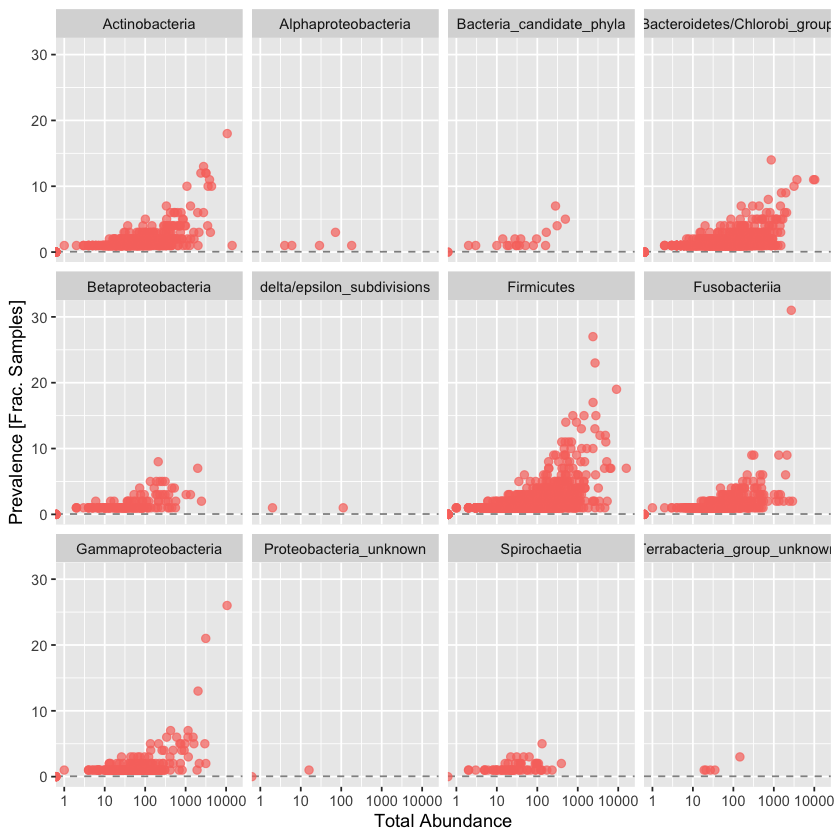

In [7]:
# compute prevalence dataframe
prevdf <- apply(X=otu_table(ps.dat), MARGIN=ifelse(taxa_are_rows(ps.dat), yes=1, no=2), FUN=function(x){sum(x>0)})
# add taxa and total read counts to dataframe
prevdf <- data.frame(Prevalence=prevdf, TotalAbundance=taxa_sums(ps.dat), tax_table(ps.dat))
# which phyla are comprised as mostly low prevalence ASVs?
lowprev <- ggplot(prevdf, aes(TotalAbundance, Prevalence, nsamples(ps.dat), color="V4")) + geom_hline(yintercept=0.05, alpha=0.5, linetype=2) + geom_point(size=2, alpha=0.7) + scale_x_log10() + xlab("Total Abundance") + ylab("Prevalence [Frac. Samples]") + facet_wrap(~V4) + theme(legend.position="none")
lowprev
pdf("totalabund_vs_prevalence.pdf")
lowprev
dev.off()
# kept asvs must be found in at least 1% of all samples 
ps.dat <- phyloseq_filter_prevalence(ps.dat, prev.trh=0.01)
ps.dat

In [8]:
# filter out samples with fewer than 1000 reads (based on ASV rareness, this shouldn't be an issue)
ps.dat <- prune_samples(sample_sums(ps.dat) > 1000, ps.dat)
ps.dat

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3390 taxa and 68 samples ]
sample_data() Sample Data:       [ 68 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 3390 taxa by 11 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3390 tips and 3389 internal nodes ]

In [9]:
# write filtered tables to file
write.table(as.data.frame(otu_table(ps.dat)), "sequence_table.filt.txt", sep="\t", row.names=T, col.names=T)
# write filtered taxonomy to file
write.table(as.data.frame(tax_table(ps.dat)), "taxonomy_bac.filt.txt", sep="\t", row.names=T, col.names=T)
# filtered metadata
write.table(as.data.frame(sample_data(ps.dat)), "map.filt.txt", sep="\t", row.names=T, col.names=T)

In [10]:
# top phyla across samples (relative abundance data)
rel.abund <- transform_sample_counts(ps.dat, function(x) x/sum(x)) # get relative abundance
glom <- tax_glom(rel.abund, taxrank=rank_names(rel.abund)[3]) # collapse 
data <- psmelt(glom) # create dataframe from phyloseq object
data$V4 <- as.character(data$V4) # convert to character
data$V4[data$Abundance < 0.01] <- "< 1% abund" # rename low freq phyla
medians <- plyr::ddply(data, ~V4, function(x) c(median=median(x$Abundance)))
medians

V4,median
<chr>,<dbl>
< 1% abund,0.00000000
Actinobacteria,0.18334463
Alphaproteobacteria,0.03163157
Bacteria_candidate_phyla,0.01572694
Bacteroidetes/Chlorobi_group,0.19877676
Betaproteobacteria,0.02786008
delta/epsilon_subdivisions,0.01051742
Firmicutes,0.41031049
Fusobacteriia,0.05364147


In [11]:
# most common genera
glom <- tax_glom(rel.abund, taxrank=rank_names(rel.abund)[8]) # collapse 
data <- psmelt(glom) # create dataframe from phyloseq object
data$V8 <- as.character(data$V8) # convert to character
data$V8[data$Abundance < 0.20] <- "< 20% abund" # rename low freq phyla
medians <- plyr::ddply(data, ~V8, function(x) c(median=median(x$Abundance)))
medians

V8,median
<chr>,<dbl>
< 20% abund,0.0000000
Bacilli_unknown,0.3522068
Cardiobacterium_valvarum,0.2228304
Corynebacterium,0.5835294
Flavobacteriaceae,0.2664971
Kytococcus,0.3927901
Leptotrichia_buccalis,0.2152198
Leptotrichia_wadei,0.3388101
Mitsuokella,0.2699748


pdf 
  2

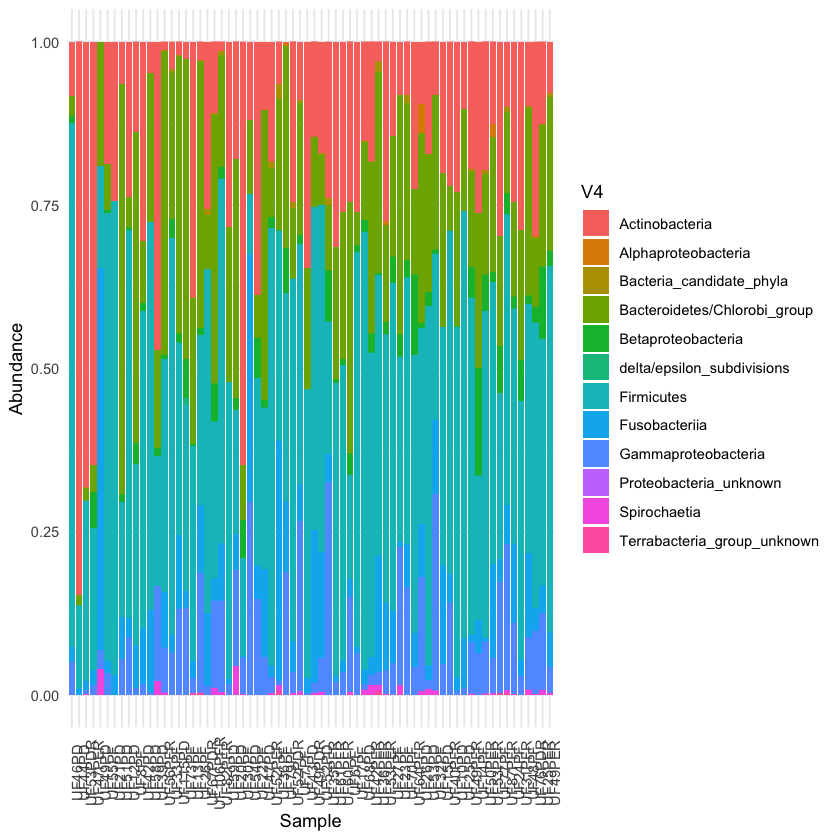

pdf 
  2

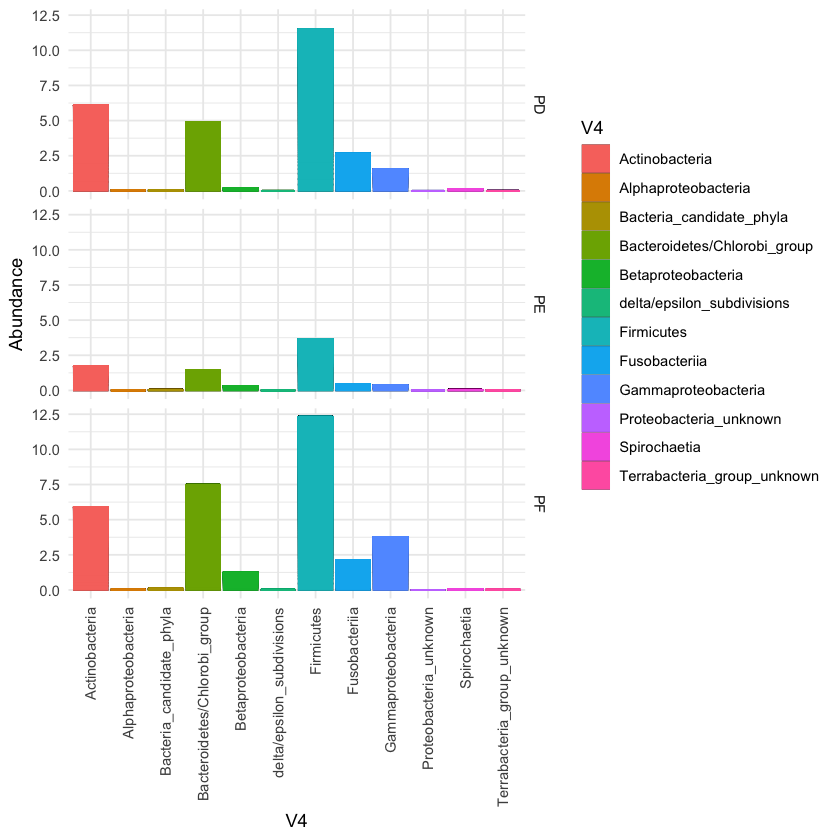

In [12]:
# phylum level figures
system("mkdir img")
data$Sample <- factor(data$Sample, levels=unique(data$Sample))
# plot by sample
taxbarsamp <- ggplot(data, aes(x=Sample, y=Abundance, fill=V4)) + geom_bar(aes(), stat="identity", position="stack") + theme_minimal() + theme(axis.text.x = element_text(angle = 90))
taxbarsamp
pdf("img/taxonomy_barchart.pdf")
taxbarsamp
dev.off()
# phyloseq group by tooth type
taxbargrp <- plot_bar(rel.abund, "V4", fill="V4", facet_grid="tooth_type") + geom_bar(aes(color=V4, fill=V4), stat="identity", position="stack")
taxbargrp + theme_minimal() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
pdf("img/tax_bar.tooth_type_by_sample.pdf")
taxbargrp
dev.off()

pdf 
  2

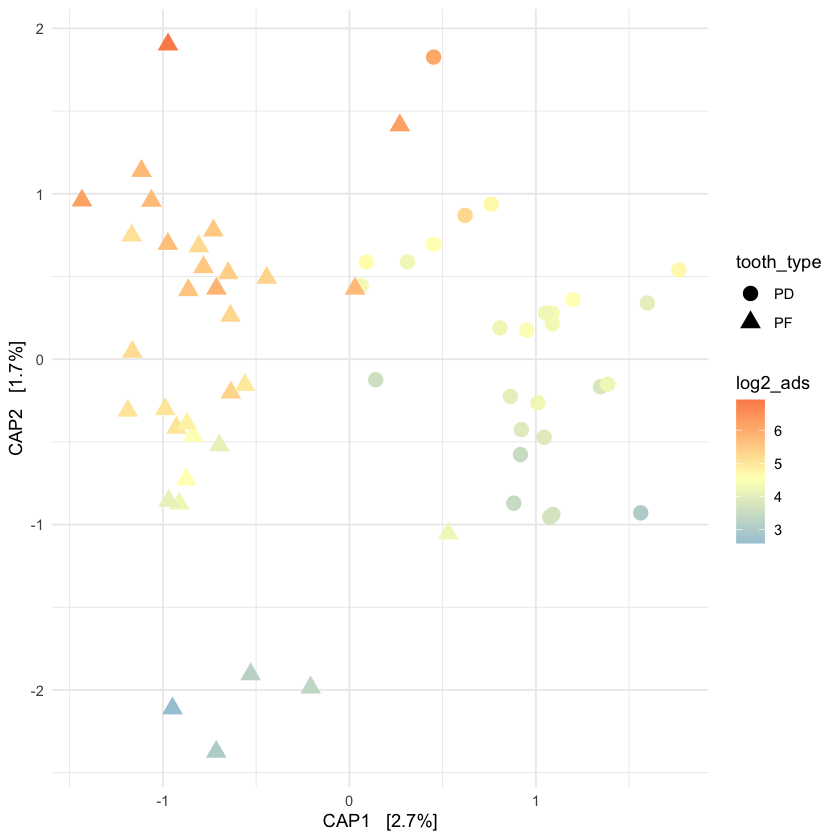

In [13]:
# only including PD and PF samples for now
ps.dat <- subset_samples(ps.dat, tooth_type !="PE")
# distance based redundancy analysis
sample_data(ps.dat)$ads_nmol_min_mg_of_protein <- as.integer(sample_data(ps.dat)$ads_nmol_min_mg_of_protein)
sample_data(ps.dat)$log2_ads <- log2(sample_data(ps.dat)$ads_nmol_min_mg_of_protein)

ordcap <- ordinate(ps.dat, "CAP", "bray", ~ tooth_type + log2_ads)
# add dummy variable to sample data as plot_ordination cannot handle only one metadata column
sample_data(ps.dat)[ , 2] <- sample_data(ps.dat)[ ,1]
mid <- median(sample_data(ps.dat)$log2_ads)
pdf("img/capscale_plt.tooth_type.pdf") 
plot_ordination(ps.dat, ordcap, color="log2_ads", shape="tooth_type") + theme_minimal() + geom_point(size=4) + scale_color_gradient2(midpoint=mid, low="#91bfdb", mid="#ffffbf", high="#fc8d59")
dev.off()
plot_ordination(ps.dat, ordcap, color="log2_ads", shape="tooth_type") + theme_minimal() + geom_point(size=4) + scale_color_gradient2(midpoint=mid, low="#91bfdb", mid="#ffffbf", high="#fc8d59")

In [14]:
# what's going on with top and bottom PD and PF?
write.table(sample_data(ps.dat), "map.txt", quote = F, sep = "\t")

In [15]:
# is the difference between the amount of arginine detected significant between tooth groups?
wilcox.test(sample_data(ps.dat)[sample_data(ps.dat)$tooth_type == "PD",]$log2_ads, sample_data(ps.dat)[sample_data(ps.dat)$tooth_type == "PF",]$log2_ads)

Warning message in wilcox.test.default(sample_data(ps.dat)[sample_data(ps.dat)$tooth_type == :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  sample_data(ps.dat)[sample_data(ps.dat)$tooth_type == "PD", ]$log2_ads and sample_data(ps.dat)[sample_data(ps.dat)$tooth_type == "PF", ]$log2_ads
W = 205, p-value = 0.0003572
alternative hypothesis: true location shift is not equal to 0


,tooth_type,individual_id,caries_status,original_sample_id,novaseq_id,volume_used_ul,protein_mg_ml,ads_nmol_min_mg_of_protein,concentration_ng_ul,Prop_Smutans,Smutans_cat,log2_ads
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<dbl>
UF33PF,PF,PF,CF,B33-PF,33PF,50,0.391,9,41.13,0.13,low,3.169925
UF36PF,PF,PF,CA,B36-PF,36PF,50,0.889,10,15.19,0.62,low,3.321928
UF40PFR,PF,PF,CF,B40-PF,40PFR,50,0.522,8,46.64,3.63,low,3.000000
UF48PF,PF,PF,CF,B48-PF,48PF,50,0.271,6,35.92,0.00,low,2.584963
UF68PD,PD,PD,CA,B68-PD,68PD,100,0.141,68,25.33,0.10,low,6.087463


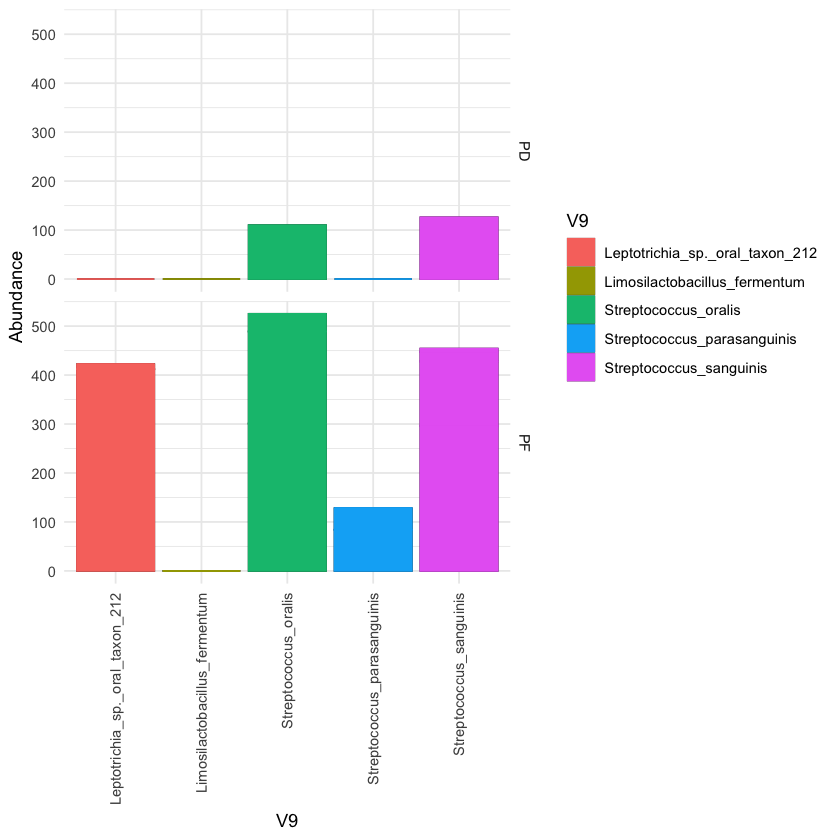

pdf 
  2

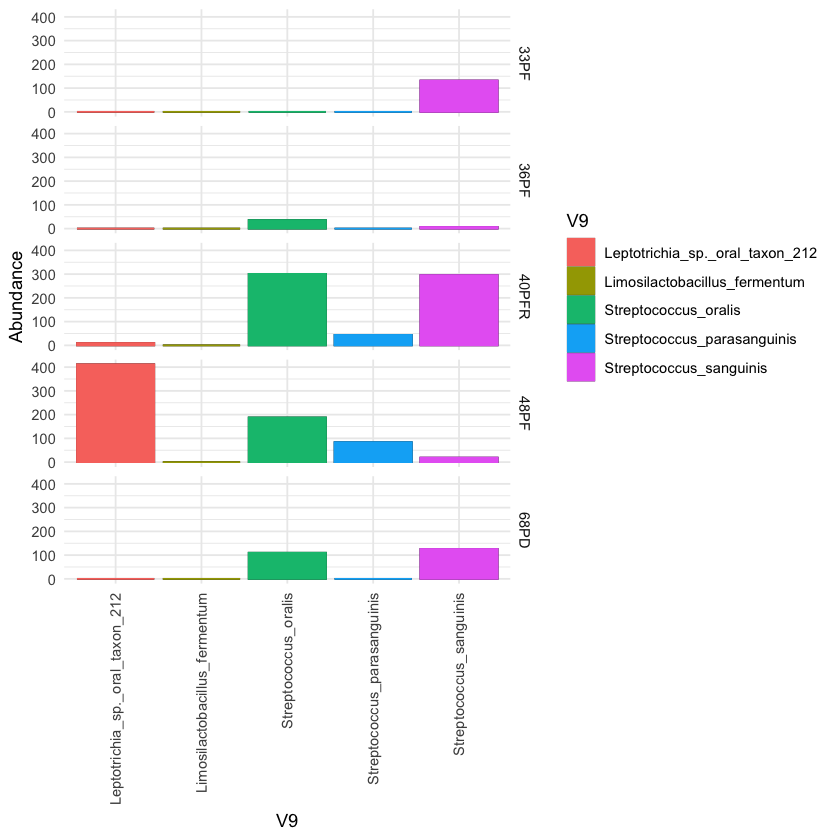

In [16]:
# what is up with low PF and high PD samples re: citrulline assay?
# samples are: UF49PF, UF33PF, UF40PFR, UF36PF, UF68PD
# sample_data(ps.dat)
x <- c("UF48PF", "UF33PF", "UF40PFR", "UF36PF", "UF68PD")
subset_lowhi_log2ADS <- phyloseq::prune_samples(x, ps.dat)
sample_data(subset_lowhi_log2ADS)
# do they have the taxa we are associating with ADS activity?
subset_lowhi_log2ADS_strep <- subset_taxa(subset_lowhi_log2ADS, V9=="Streptococcus_sanguinis" | V9=="Streptococcus_parasanguinis" | V9=="Streptococcus_oralis" | V9=="Limosilactobacillus_fermentum" | V9=="Leptotrichia_sp._oral_taxon_212")
glom <- tax_glom(subset_lowhi_log2ADS_strep, taxrank=rank_names(subset_lowhi_log2ADS_strep)[8])
# # what is proportion of species tagged in volcano plot in pd vs pf?
taxbargrp <- plot_bar(glom, "V9", fill="V9", facet_grid="tooth_type") + geom_bar(aes(color=V9, fill=V9), stat="identity", position="stack")
taxbargrp + theme_minimal() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
# by sample
taxbargrp <- plot_bar(glom, "V9", fill="V9", facet_grid="novaseq_id") + geom_bar(aes(color=V9, fill=V9), stat="identity", position="stack")
taxbargrp + theme_minimal() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
pdf("lowhi_ADS_prop_species.pdf")
taxbargrp + theme_minimal() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
dev.off()

pdf 
  2

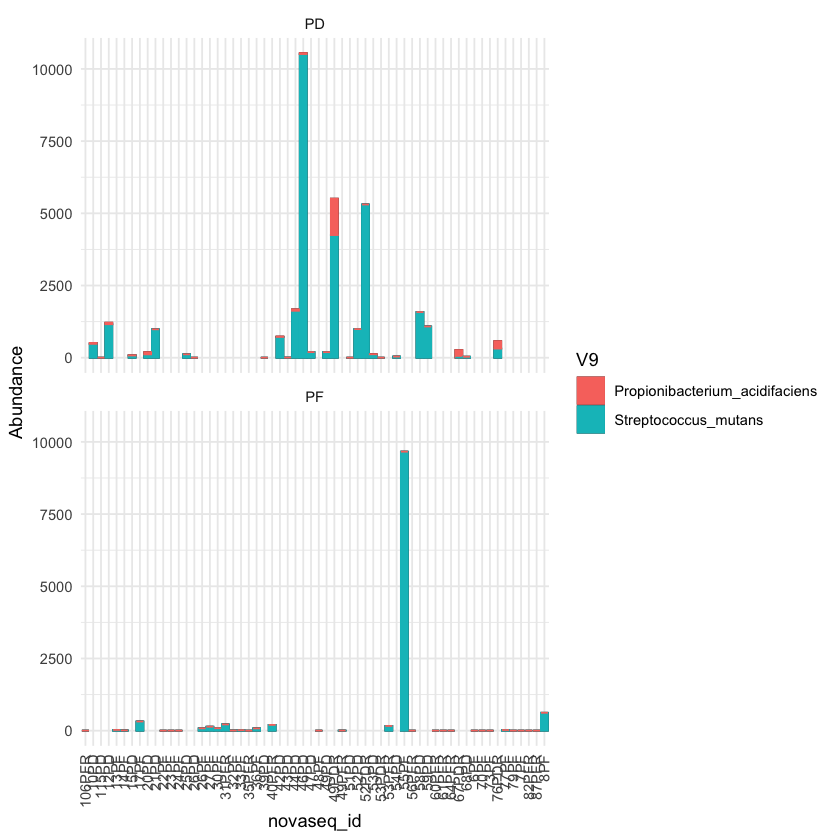

In [17]:
# also want to know the proportion of S mutans and P acidifaciens across PD samples. Are there some that are dominanted by one or the other?
sub <- subset_taxa(ps.dat, V9=="Streptococcus_mutans" | V9=="Propionibacterium_acidifaciens")
glom <- tax_glom(sub, taxrank=rank_names(sub)[8])
# by sample
taxbargrp <- plot_bar(glom, "novaseq_id", fill="V9", facet_grid="V9") + geom_bar(aes(color=V9, fill=V9), stat="identity", position="stack") + facet_wrap(~tooth_type, ncol=1)
taxbargrp + theme_minimal() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) 
pdf("prop_smutans_pacidifaciens.pdf")
taxbargrp + theme_minimal() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
dev.off()

In [18]:
# philr transform data and distance matrix to perform permanova statistics
philr.dat <- transform_sample_counts(ps.dat, function(x) x+1) # add pseudocount of one to ASVs to avoid log-ratios calculated from zero
is.rooted(phy_tree(philr.dat)) # check that tree is rooted
is.binary(phy_tree(philr.dat)) #check that multichotomies are resolved in tree
phy_tree(philr.dat) <- makeNodeLabel(phy_tree(philr.dat), method="number", prefix="n")                                    
asv.table <- otu_table(philr.dat)
tree <- phy_tree(philr.dat)
metadata <- sample_data(philr.dat)
tax <- tax_table(philr.dat)
philr.t <- philr(t(asv.table), tree, part.weights="enorm.x.gm.counts", ilr.weights="blw.sqrt")
# distance matrix
philr.dist <- dist(philr.t, method="euclidean")

[1] TRUE

[1] TRUE

Building Sequential Binary Partition from Tree...

Building Contrast Matrix...

Transforming the Data...

Calculating ILR Weights...



In [19]:
# permanova test
metadata <- as(sample_data(philr.dat), "data.frame")
adonis2(philr.dist ~ tooth_type, data=metadata)

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
tooth_type,1,65.14508,0.04576604,2.781739,0.001
Residual,58,1358.29208,0.95423396,NA,NA
Total,59,1423.43715,1.00000000,NA,NA


In [20]:
# marginal effect of ads amount after controlling for tooth type
adonis2(philr.dist ~ tooth_type + log2_ads, data=metadata)

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
tooth_type,1,65.14508,0.04576604,2.808236,0.001
log2_ads,1,36.01400,0.02530073,1.552471,0.042
Residual,57,1322.27808,0.92893323,NA,NA
Total,59,1423.43715,1.00000000,NA,NA



	Homogeneity of multivariate dispersions

Call: vegan::betadisper(d = philr.dist, group =
phyloseq::sample_data(philr.dat)$tooth_type)

No. of Positive Eigenvalues: 59
No. of Negative Eigenvalues: 0

Average distance to median:
   PD    PF 
4.612 4.270 

Eigenvalues for PCoA axes:
(Showing 8 of 59 eigenvalues)
 PCoA1  PCoA2  PCoA3  PCoA4  PCoA5  PCoA6  PCoA7  PCoA8 
154.64 134.14  96.05  80.16  63.73  55.54  50.14  46.56 


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
          Df  Sum Sq Mean Sq     F N.Perm Pr(>F)
Groups     1   1.735  1.7353 0.529    999  0.469
Residuals 58 190.255  3.2803                    

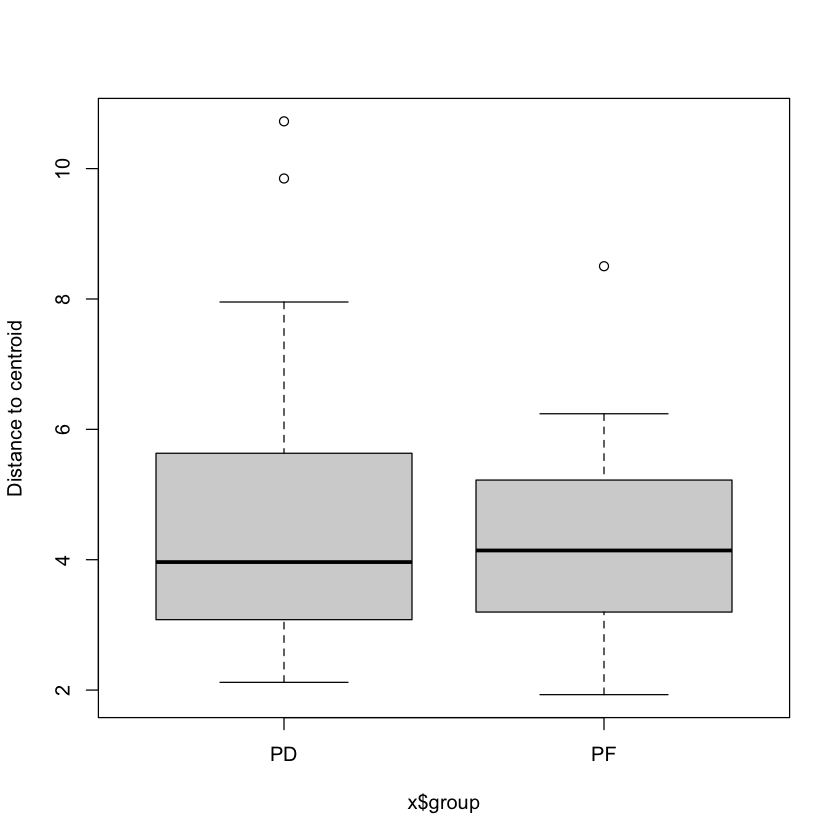

In [21]:
# beta dispersion test
dispr <- vegan::betadisper(philr.dist, phyloseq::sample_data(philr.dat)$tooth_type)
dispr
permutest(dispr)
boxplot(dispr)

pdf 
  2

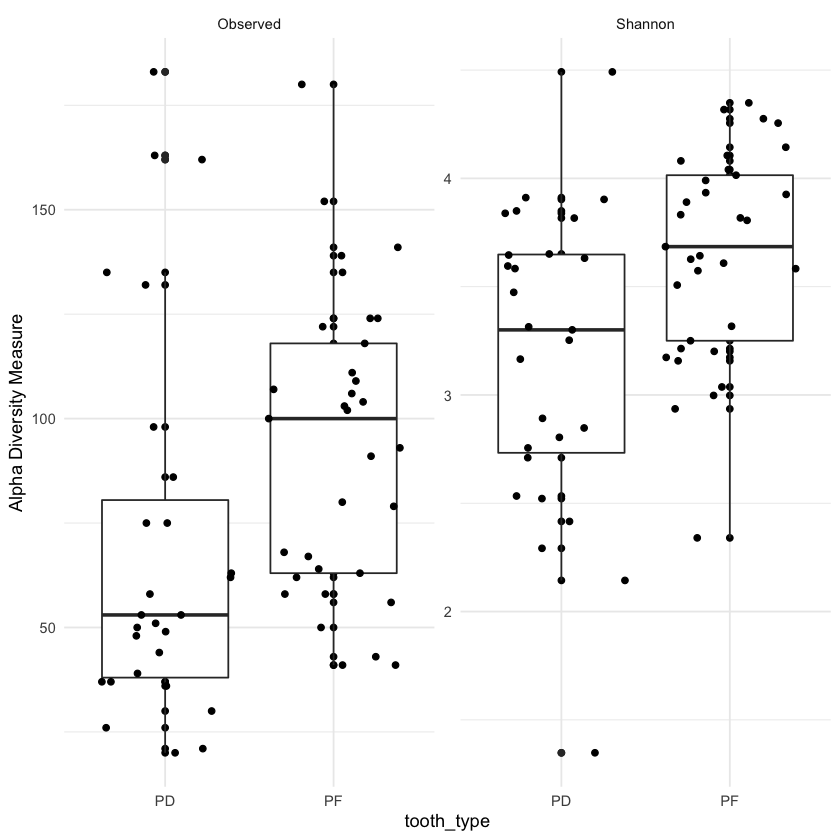

In [22]:
# alpha diversity
pdf("img/alpha_div.tooth_type.pdf")
plot_richness(ps.dat, measures=c("Observed", "Shannon"), x="tooth_type") + geom_boxplot() + theme_minimal() + geom_jitter()
dev.off()
plot_richness(ps.dat, measures=c("Observed", "Shannon"), x="tooth_type") + geom_boxplot() + theme_minimal() + geom_jitter()

pdf 
  2

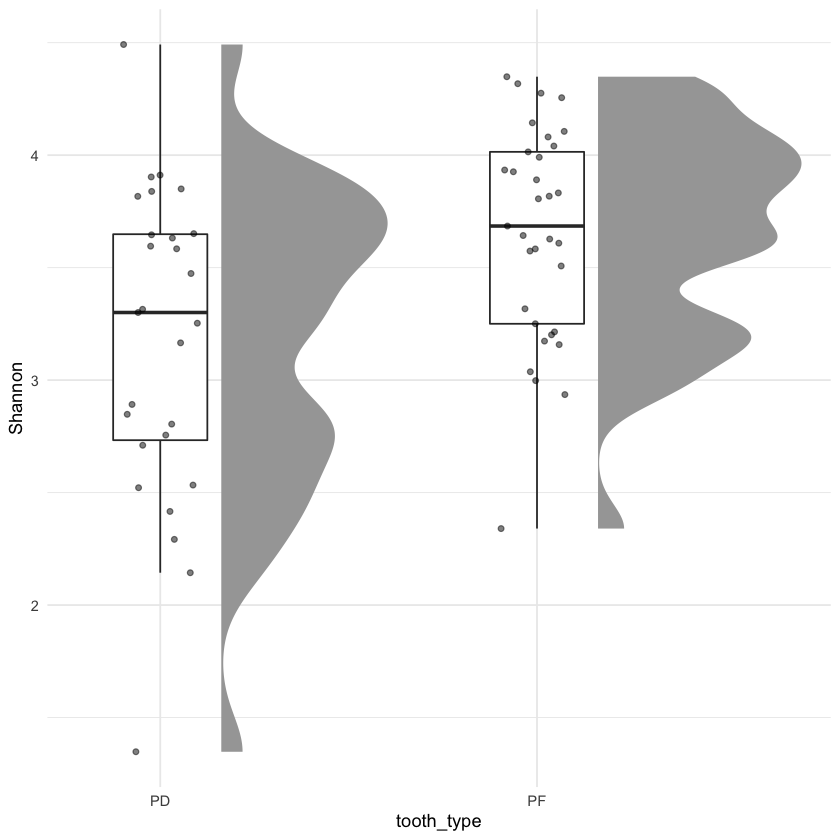

In [23]:
# install.packages("ggdist")
library(ggdist)
temp <- estimate_richness(subset_samples(ps.dat, tooth_type == "PD"))
temp$tooth_type <- "PD"
temp1 <- estimate_richness(subset_samples(ps.dat, tooth_type == "PF"))
temp1$tooth_type <- "PF"
alpha2 <- bind_rows(temp, temp1)

# raincloud plot
p <- ggplot(alpha2, aes(x = tooth_type, y = Shannon)) + 
  ggdist::stat_halfeye(
    adjust = .5, 
    width = .6, 
    .width = 0, 
    justification = -.3, 
    point_colour = NA) + 
  geom_boxplot(
    width = .25, 
    outlier.shape = NA
  ) +
  geom_point(
    size = 1.3,
    alpha = .5,
    position = position_jitter(
      seed = 1, width = .1
    )
  ) + 
    theme_minimal() +
  coord_cartesian(xlim = c(1.3, NA))
p
pdf("alphdiv_raincloud.pdf")
p
dev.off()

In [24]:
# significance tests
wilcox.test(estimate_richness(subset_samples(ps.dat, tooth_type == "PD"))$Observed, estimate_richness(subset_samples(ps.dat, tooth_type == "PF"))$Observed)
wilcox.test(estimate_richness(subset_samples(ps.dat, tooth_type == "PD"))$Shannon, estimate_richness(subset_samples(ps.dat, tooth_type == "PF"))$Shannon)

Warning message in wilcox.test.default(estimate_richness(subset_samples(ps.dat, :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  estimate_richness(subset_samples(ps.dat, tooth_type == "PD"))$Observed and estimate_richness(subset_samples(ps.dat, tooth_type == "PF"))$Observed
W = 254, p-value = 0.004532
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  estimate_richness(subset_samples(ps.dat, tooth_type == "PD"))$Shannon and estimate_richness(subset_samples(ps.dat, tooth_type == "PF"))$Shannon
W = 256, p-value = 0.004423
alternative hypothesis: true location shift is not equal to 0


Warning message in FUN(X[[i]], ...):
“merge_taxa attempted to reduce tree to 1 or fewer tips.
 tree replaced with NULL.”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 14 rows containing non-finite values (stat_smooth).”


geom_rug: outside = FALSE, sides = bl, length = 0.03, na.rm = FALSE
stat_identity: na.rm = FALSE
position_identity 

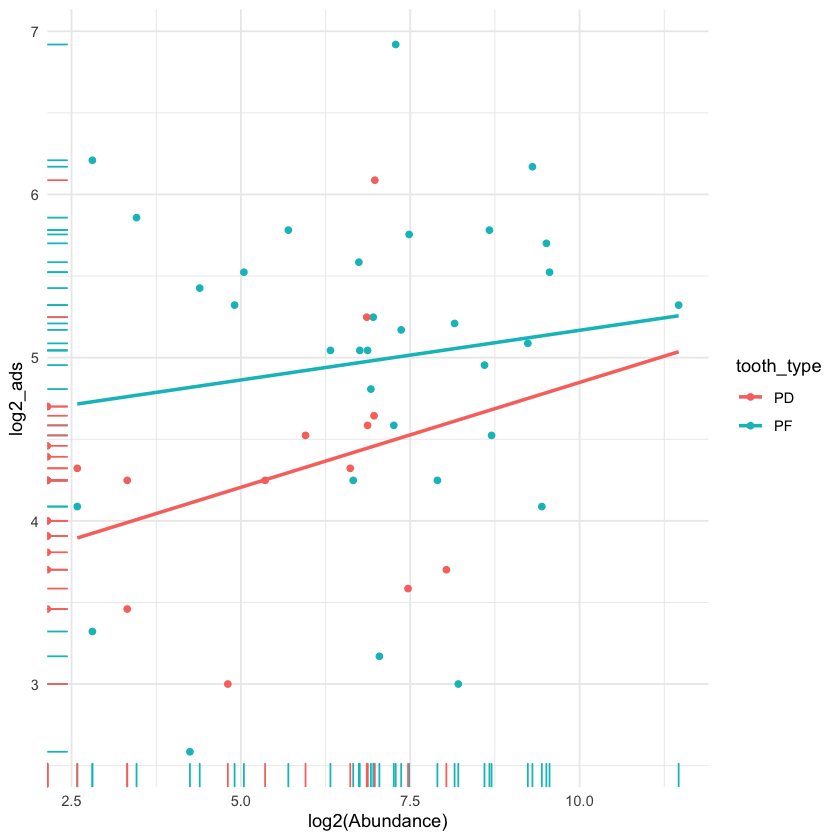

In [25]:
# proportion of different types of strep in pd vs pf
strep <- subset_taxa(ps.dat, V9=="Streptococcus_sanguinis")
glom <- tax_glom(strep, taxrank=rank_names(strep)[8])
data <- psmelt(glom) # create dataframe from phyloseq object
data$Sample <- factor(data$Sample, levels=unique(data$Sample))
# plot
ggplot(data, aes(x=log2(Abundance), y=log2_ads, color=tooth_type)) + 
    geom_point() + 
    theme_minimal() + 
    geom_smooth(method=lm, se=FALSE, fullrange=TRUE) +
    geom_rug()
geom_rug(sides ="bl")

Warning message in FUN(X[[i]], ...):
“merge_taxa attempted to reduce tree to 1 or fewer tips.
 tree replaced with NULL.”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 26 rows containing non-finite values (stat_smooth).”


geom_rug: outside = FALSE, sides = bl, length = 0.03, na.rm = FALSE
stat_identity: na.rm = FALSE
position_identity 

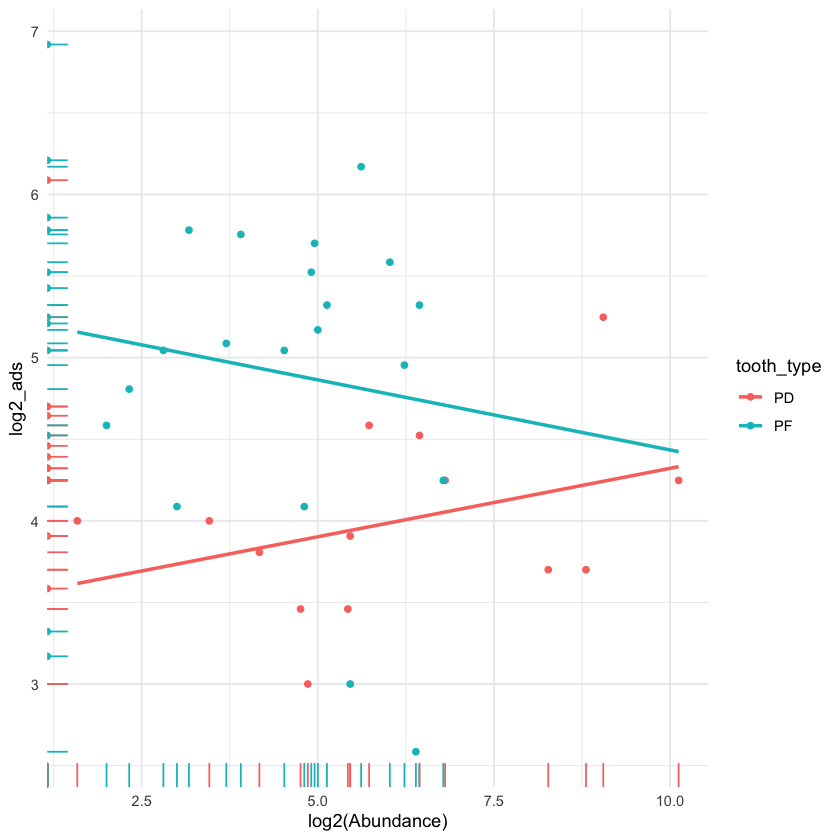

In [26]:
# proportion of different types of strep in pd vs pf
strep <- subset_taxa(ps.dat, V9=="Streptococcus_parasanguinis")
glom <- tax_glom(strep, taxrank=rank_names(strep)[8])
data <- psmelt(glom) # create dataframe from phyloseq object
data$Sample <- factor(data$Sample, levels=unique(data$Sample))
# plot
ggplot(data, aes(x=log2(Abundance), y=log2_ads, color=tooth_type)) + 
    geom_point() + 
    theme_minimal() + 
    geom_smooth(method=lm, se=FALSE, fullrange=TRUE) +
    geom_rug()
geom_rug(sides ="bl")

Warning message in FUN(X[[i]], ...):
“merge_taxa attempted to reduce tree to 1 or fewer tips.
 tree replaced with NULL.”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 26 rows containing non-finite values (stat_smooth).”


geom_rug: outside = FALSE, sides = bl, length = 0.03, na.rm = FALSE
stat_identity: na.rm = FALSE
position_identity 

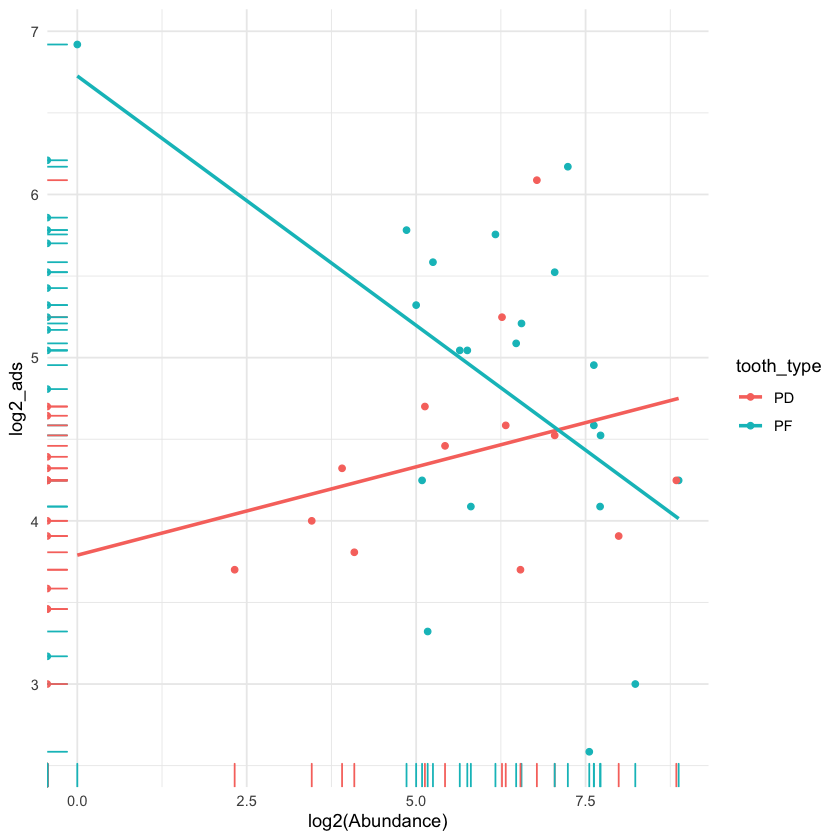

In [27]:
# proportion of different types of strep in pd vs pf
strep <- subset_taxa(ps.dat, V9=="Streptococcus_oralis")
glom <- tax_glom(strep, taxrank=rank_names(strep)[8])
data <- psmelt(glom) # create dataframe from phyloseq object
data$Sample <- factor(data$Sample, levels=unique(data$Sample))
# plot
ggplot(data, aes(x=log2(Abundance), y=log2_ads, color=tooth_type)) + 
    geom_point() + 
    theme_minimal() + 
    geom_smooth(method=lm, se=FALSE, fullrange=TRUE) +
    geom_rug()
geom_rug(sides ="bl")

Warning message in FUN(X[[i]], ...):
“merge_taxa attempted to reduce tree to 1 or fewer tips.
 tree replaced with NULL.”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 25 rows containing non-finite values (stat_smooth).”


geom_rug: outside = FALSE, sides = bl, length = 0.03, na.rm = FALSE
stat_identity: na.rm = FALSE
position_identity 

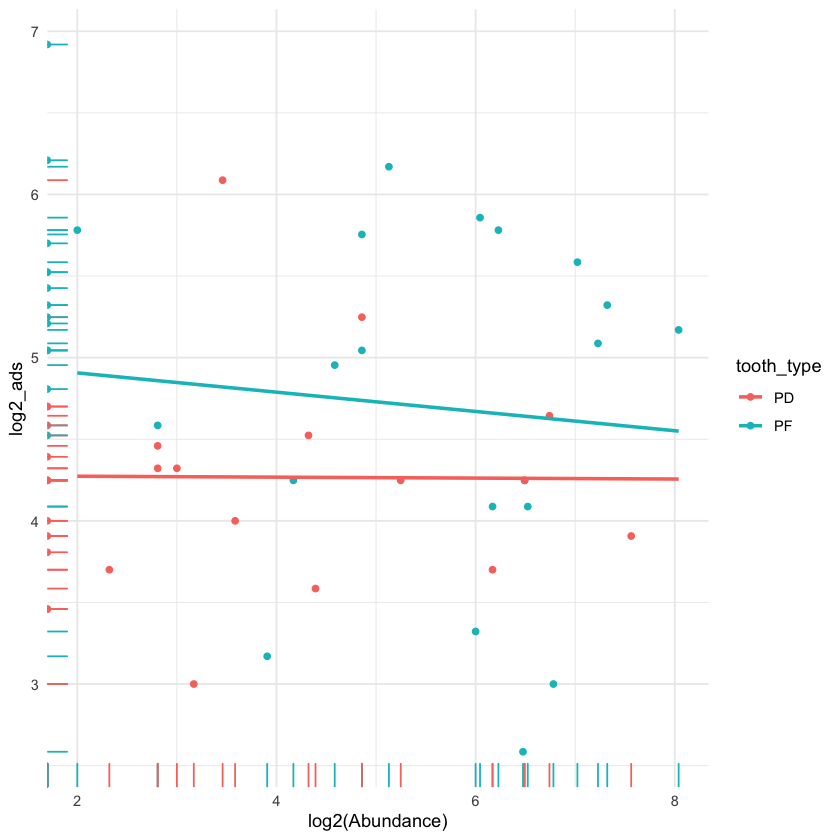

In [28]:
# proportion of different types of strep in pd vs pf
strep <- subset_taxa(ps.dat, V9=="Streptococcus_gordonii")
glom <- tax_glom(strep, taxrank=rank_names(strep)[8])
data <- psmelt(glom) # create dataframe from phyloseq object
data$Sample <- factor(data$Sample, levels=unique(data$Sample))
# plot
ggplot(data, aes(x=log2(Abundance), y=log2_ads, color=tooth_type)) + 
    geom_point() + 
    theme_minimal() + 
    geom_smooth(method=lm, se=FALSE, fullrange=TRUE) +
    geom_rug()
geom_rug(sides ="bl")

Warning message in FUN(X[[i]], ...):
“merge_taxa attempted to reduce tree to 1 or fewer tips.
 tree replaced with NULL.”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 24 rows containing non-finite values (stat_smooth).”


geom_rug: outside = FALSE, sides = bl, length = 0.03, na.rm = FALSE
stat_identity: na.rm = FALSE
position_identity 

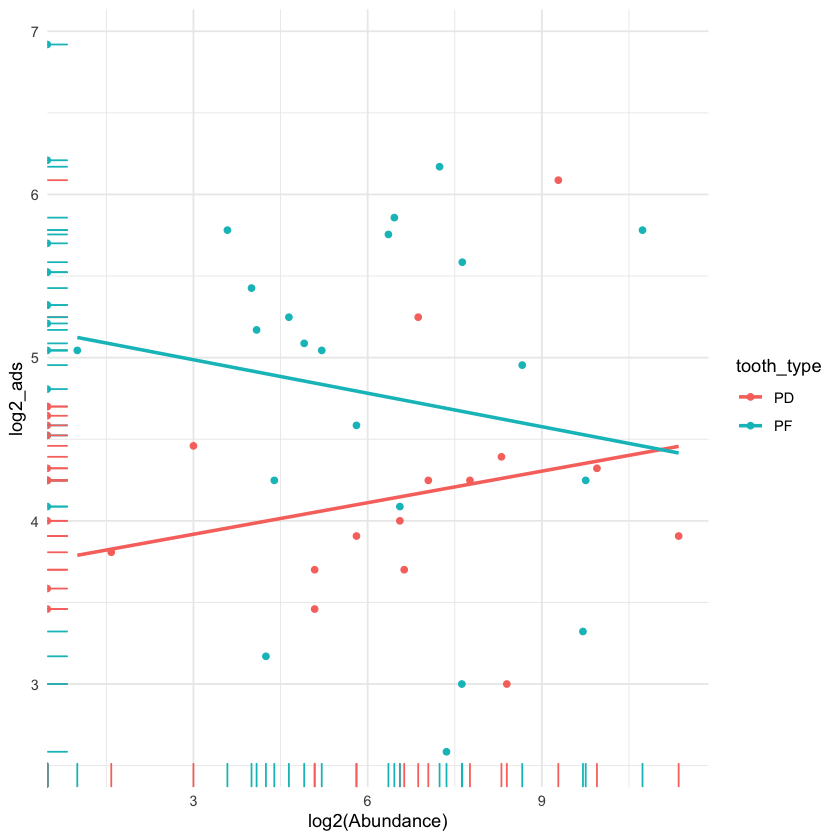

In [29]:
# proportion of different types of strep in pd vs pf
strep <- subset_taxa(ps.dat, V9=="Streptococcus_anginosus_group") # includes both constellatus and aginosus
glom <- tax_glom(strep, taxrank=rank_names(strep)[8])
data <- psmelt(glom) # create dataframe from phyloseq object
data$Sample <- factor(data$Sample, levels=unique(data$Sample))
# plot
ggplot(data, aes(x=log2(Abundance), y=log2_ads, color=tooth_type)) + 
    geom_point() + 
    theme_minimal() + 
    geom_smooth(method=lm, se=FALSE, fullrange=TRUE) +
    geom_rug()
geom_rug(sides ="bl")

,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12
ASV2843,Bacteria,Terrabacteria_group,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,Streptococcus_anginosus_group,Streptococcus_constellatus,Streptococcus_constellatus_subsp._pharyngis,Streptococcus_constellatus_subsp._pharyngis_unknown
ASV2475,Bacteria,Terrabacteria_group,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,Streptococcus_anginosus_group,Streptococcus_constellatus,Streptococcus_constellatus_subsp._pharyngis,Streptococcus_constellatus_subsp._pharyngis_unknown
ASV643,Bacteria,Terrabacteria_group,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,Streptococcus_anginosus_group,Streptococcus_constellatus,Streptococcus_constellatus_subsp._pharyngis,Streptococcus_constellatus_subsp._pharyngis_unknown
ASV988,Bacteria,Terrabacteria_group,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,Streptococcus_anginosus_group,Streptococcus_constellatus,Streptococcus_constellatus_subsp._pharyngis,Streptococcus_constellatus_subsp._pharyngis_unknown


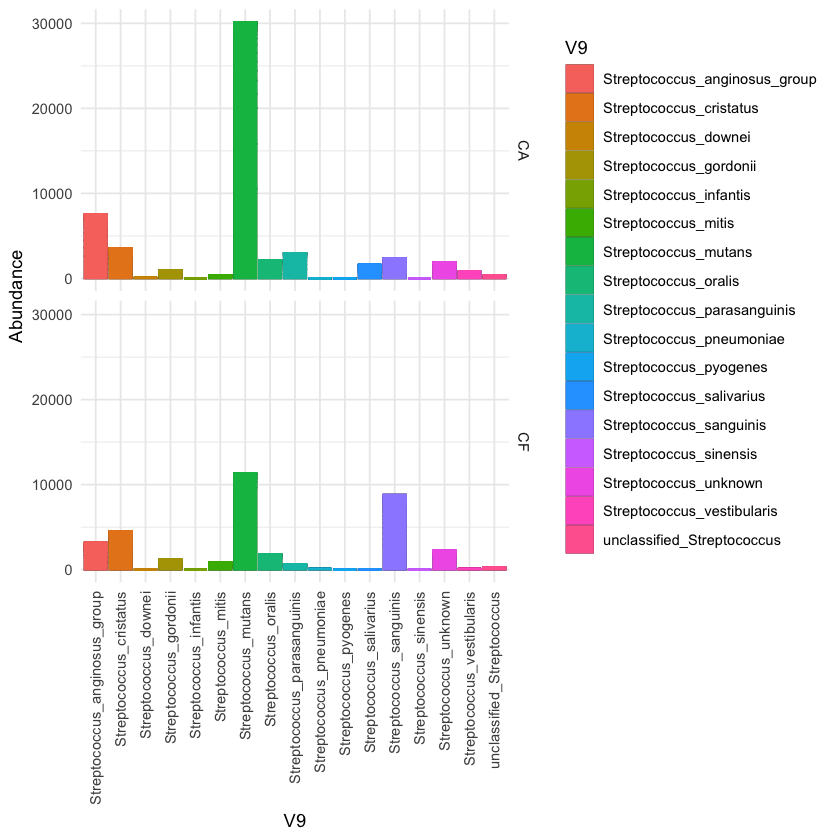

In [30]:
strep <- subset_taxa(ps.dat, V8=="Streptococcus")
glom <- tax_glom(strep, taxrank=rank_names(strep)[8])
# what is proportion of different strep species in pd vs pf?
taxbargrp <- plot_bar(glom, "V9", fill="V9", facet_grid="caries_status") + geom_bar(aes(color=V9, fill=V9), stat="identity", position="stack")
taxbargrp + theme_minimal() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

tax_table(subset_taxa(ps.dat, V10=="Streptococcus_constellatus"))

pdf 
  2

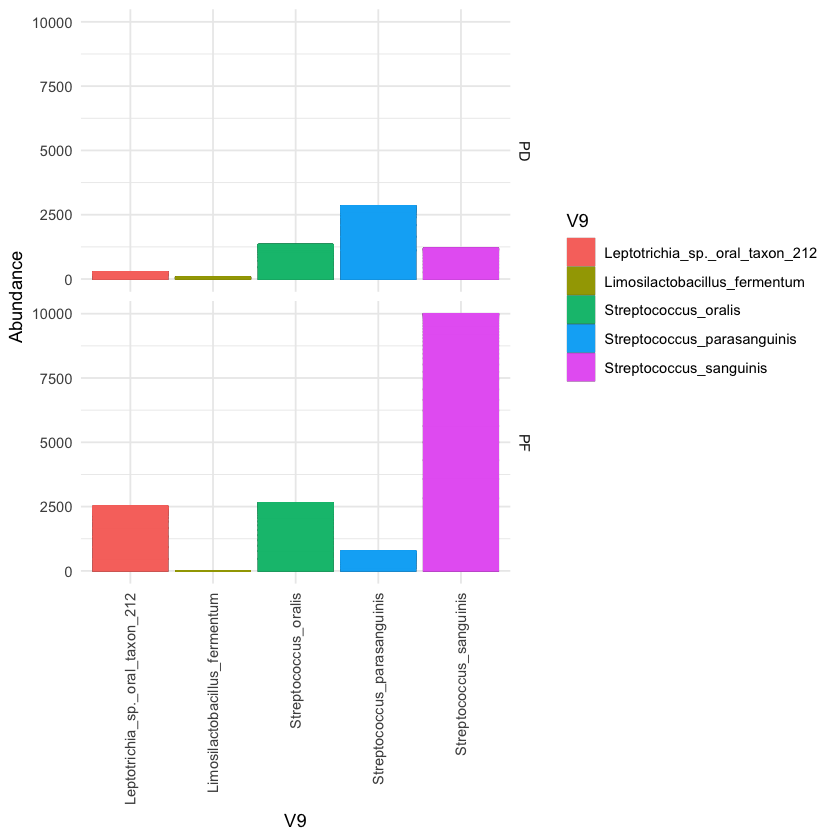

In [31]:
strep <- subset_taxa(ps.dat, V9=="Streptococcus_sanguinis" | V9=="Streptococcus_parasanguinis" | V9=="Streptococcus_oralis" | V9=="Limosilactobacillus_fermentum" | V9=="Leptotrichia_sp._oral_taxon_212")
glom <- tax_glom(strep, taxrank=rank_names(strep)[8])
# what is proportion of species tagged in volcano plot in pd vs pf?
taxbargrp <- plot_bar(glom, "V9", fill="V9", facet_grid="tooth_type") + geom_bar(aes(color=V9, fill=V9), stat="identity", position="stack")
pdf("bar_matching_volcano_plot.pdf")
taxbargrp + theme_minimal() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
dev.off()
taxbargrp + theme_minimal() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

pdf 
  2

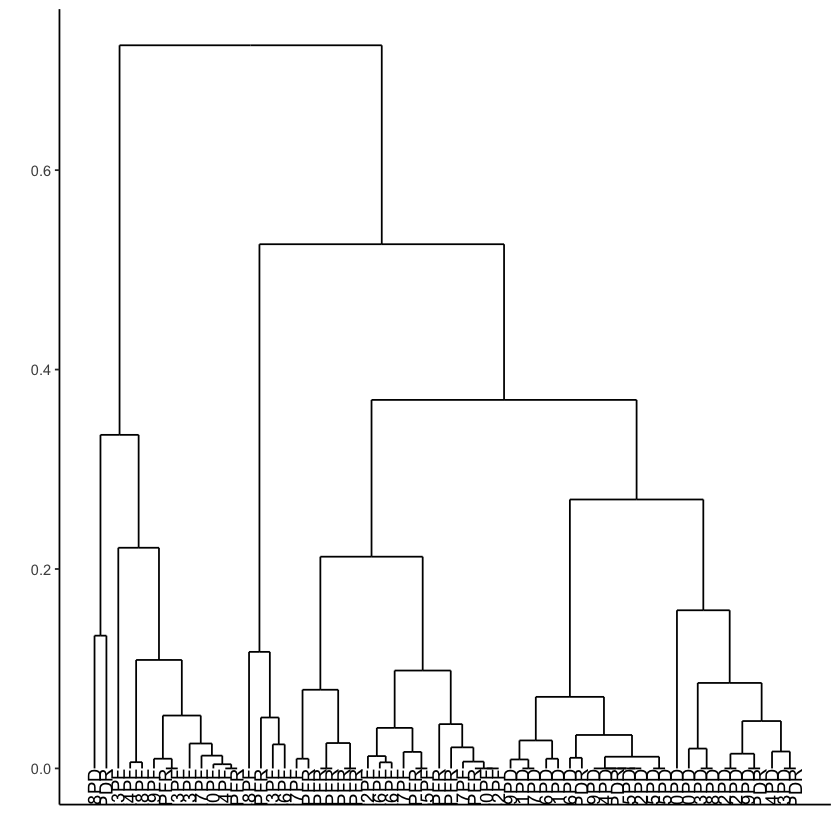

In [32]:
# heirarchical cluster dendrogram with corresponding taxonomy plot 
hc <- hclust(dist(ordcap$CCA$u), method="complete")
df2 <- data.frame(cluster=cutree(hc,5), states=factor(hc$labels, levels=hc$labels[hc$order])) # get cluster assocaited with each sample
write.table(df2, "philr_cluster.txt", quote=F, sep="\t", col.names=NA)
hcd <- as.dendrogram(hc)
dend_data <- dendro_data(hcd, type="rectangle")
tip_labels <- as.vector(dend_data$labels$label)
ggplot(dend_data$segments) +
    geom_segment(aes(x=x,y=y, xend=xend, yend=yend)) +
    theme_classic() +
    geom_text(data = dend_data$labels, aes(x, y, label = label, hjust = 1, angle = 90)) + 
    xlab("") + 
    ylab("") + 
    theme(axis.text.x=element_blank(), axis.ticks.x=element_blank()) 
pdf("bdiv_dendrogram.pdf")
ggplot(dend_data$segments) +
    geom_segment(aes(x=x,y=y, xend=xend, yend=yend)) +
    theme_classic() +
    geom_text(data = dend_data$labels, aes(x, y, label = label, hjust = 1, angle = 90)) + 
    xlab("") + 
    ylab("") + 
    theme(axis.text.x=element_blank(), axis.ticks.x=element_blank()) 
dev.off()

In [33]:
dend_data$labels

x,y,label
<dbl>,<dbl>,<chr>
1,0,UF68PD
2,0,UF76PDR
3,0,UF23PF
4,0,UF24PF
5,0,UF8PF
6,0,UF79PF
7,0,UF64PFR
8,0,UF73PF
9,0,UF13PF


In [34]:
# differential abundance data
library(DESeq2)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following object is masked from ‘package:gridExtra’:

    combine


The following object is masked from ‘package:randomForest’:

    combine


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following objects are masked from 

In [35]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur 10.16

Matrix products: default
BLAS/LAPACK: /Users/mann/miniconda3/envs/2022-ADS_plaque-R/lib/libopenblasp-r0.3.20.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] DESeq2_1.34.0               SummarizedExperiment_1.24.0
 [3] Biobase_2.54.0              MatrixGenerics_1.6.0       
 [5] matrixStats_0.62.0          GenomicRanges_1.46.1       
 [7] GenomeInfoDb_1.30.1         IRanges_2.28.0             
 [9] S4Vectors_0.32.4            BiocGenerics_0.40.0        
[11] ggdist_3.2.0                ggdendro_0.1.23            
[13] MASS_7.3-58.1               ranacapa_0.1.0             
[15] metagMisc_0.0.4             pairwiseAdonis_0.4         
[17] cluster_2.1.4               vegan_2.6-4                
[19] lattice

In [36]:
head(sample_data(ps.dat))

,tooth_type,individual_id,caries_status,original_sample_id,novaseq_id,volume_used_ul,protein_mg_ml,ads_nmol_min_mg_of_protein,concentration_ng_ul,Prop_Smutans,Smutans_cat,log2_ads
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<dbl>
UF106PFR,PF,PF,CA,B106-PFR,106PFR,80,0.399,17,14.46,0.00,low,4.087463
UF10PD,PD,PD,CA,B10-PD,10PD,120,0.153,8,7.74,10.45,high,3.000000
UF115PD,PD,PD,CA,B115-PD,115PD,120,0.083,20,26.51,0.00,low,4.321928
UF12PD,PD,PD,CA,B12-PD,12PD,80,0.222,16,5.29,42.47,high,4.000000
UF13PF,PF,PF,CF,B13-PF,13PF,40,0.380,58,25.43,0.58,low,5.857981
UF14PF,PF,PF,CF,B14-PF,14PF,40,0.266,55,36.07,0.19,low,5.781360


In [37]:
difabund <- phyloseq_to_deseq2(ps.dat, ~ tooth_type)

gm_mean = function(x, na.rm=TRUE){
  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
}

geoMeans <- apply(counts(difabund), 1, gm_mean)
difabund <- estimateSizeFactors(difabund, geoMeans = geoMeans)
res <- DESeq(difabund, fitType="local")

sigtab <- results(res)
sigtab <- sigtab[order(sigtab$padj, na.last = NA),]
sigtab <- sigtab[(sigtab$padj < 0.05),]
sigtab <- cbind(as(sigtab, "data.frame"), as(tax_table(ps.dat)[rownames(sigtab),], "matrix"))
sigtab


converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 2627 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
ASV114,14.900441,23.79253,2.178378,10.922128,9.035337e-28,9.107619e-25,Bacteria,Terrabacteria_group,Firmicutes,Bacilli,Lactobacillales,Carnobacteriaceae,Granulicatella,Granulicatella_adiacens,Granulicatella_adiacens_ATCC_49175,Granulicatella_adiacens_ATCC_49175_unknown,Granulicatella_adiacens_ATCC_49175_unknown
ASV18,20.408171,24.29364,2.462313,9.866189,5.833914e-23,2.940293e-20,Bacteria,Terrabacteria_group,Actinobacteria,Actinomycetia,Micrococcales,Micrococcaceae,Rothia,Rothia_aeria,Rothia_aeria_F0184,Rothia_aeria_F0184_unknown,Rothia_aeria_F0184_unknown
ASV72,12.821585,23.64732,2.442161,9.682945,3.563000e-22,1.197168e-19,Bacteria,Terrabacteria_group,Firmicutes,Negativicutes,Veillonellales,Veillonellaceae,Veillonella,Veillonella_parvula,Veillonella_parvula_DSM_2008,Veillonella_parvula_DSM_2008_unknown,Veillonella_parvula_DSM_2008_unknown
ASV249,12.072657,23.56260,2.447905,9.625618,6.233134e-22,1.570750e-19,Bacteria,Terrabacteria_group,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,Streptococcus_sanguinis,Streptococcus_sanguinis_VMC66,Streptococcus_sanguinis_VMC66_unknown,Streptococcus_sanguinis_VMC66_unknown
ASV62,10.673244,23.29868,2.436348,9.562950,1.144468e-21,2.307247e-19,Bacteria,Proteobacteria,Gammaproteobacteria,Pasteurellales,Pasteurellaceae,Haemophilus,Haemophilus_unknown,Haemophilus_unknown,Haemophilus_unknown,Haemophilus_unknown,Haemophilus_unknown
ASV63,31.234650,24.88297,2.618157,9.504004,2.019705e-21,3.393105e-19,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Burkholderiaceae,Lautropia,Lautropia_mirabilis,Lautropia_mirabilis_ATCC_51599,Lautropia_mirabilis_ATCC_51599_unknown,Lautropia_mirabilis_ATCC_51599_unknown,Lautropia_mirabilis_ATCC_51599_unknown
ASV74,26.413971,-25.77881,2.738789,-9.412486,4.845368e-21,6.977330e-19,Bacteria,Terrabacteria_group,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,Streptococcus_parasanguinis,Streptococcus_parasanguinis_FW213,Streptococcus_parasanguinis_FW213_unknown,Streptococcus_parasanguinis_FW213_unknown
ASV65,35.518284,23.35643,2.623763,8.901880,5.490853e-19,6.918474e-17,Bacteria,FCB_group,Bacteroidetes/Chlorobi_group,Bacteroidetes,Bacteroidia,Bacteroidales,Porphyromonadaceae,Porphyromonas,unclassified_Porphyromonas,Porphyromonas_sp._oral_taxon_279,Porphyromonas_sp._oral_taxon_279_str._F0450
ASV150,12.336754,-24.73941,2.922128,-8.466232,2.534591e-17,2.838742e-15,Bacteria,Terrabacteria_group,Actinobacteria,Actinomycetia,Micrococcales,Micrococcaceae,Rothia,Rothia_mucilaginosa,Rothia_mucilaginosa_unknown,Rothia_mucilaginosa_unknown,Rothia_mucilaginosa_unknown


pdf 
  2

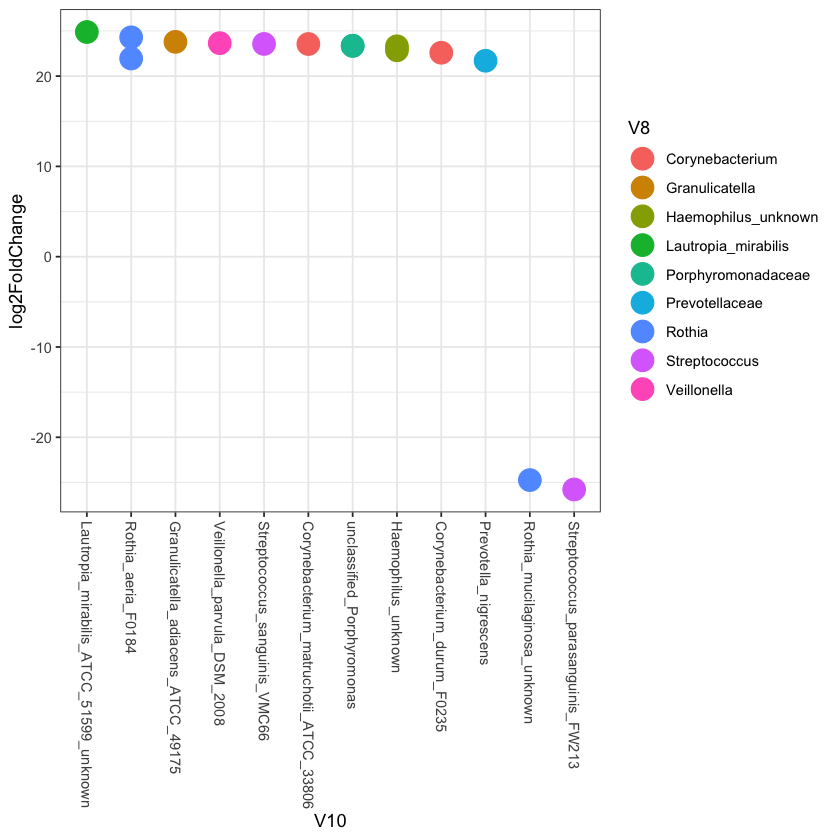

In [38]:
theme_set(theme_bw())
scale_fill_discrete <- function(palname = "Set1", ...) {
    scale_fill_brewer(palette = palname, ...)
}
# Phylum order
x = tapply(sigtab$log2FoldChange, sigtab$V10, function(x) max(x))
x = sort(x, TRUE)
sigtab$V10 = factor(as.character(sigtab$V10), levels=names(x))
# Genus order
x = tapply(sigtab$log2FoldChange, sigtab$V10, function(x) max(x))
x = sort(x, TRUE)
sigtab$V10 = factor(as.character(sigtab$V10), levels=names(x))
ggplot(sigtab, aes(x=V10, y=log2FoldChange, color=V8)) + geom_point(size=6) + 
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
pdf("diff_abundance.pdf")
ggplot(sigtab, aes(x=V10, y=log2FoldChange, color=V8)) + geom_point(size=6) + 
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
dev.off()

In [39]:
sigtab <- results(res)
sigtab <- sigtab[order(sigtab$padj, na.last = NA),]
sigtab <- sigtab[(sigtab$padj < 0.05),]
sigtab <- cbind(as(sigtab, "data.frame"), as(tax_table(ps.dat)[rownames(sigtab),], "matrix"))
sigtab

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
ASV114,14.900441,23.79253,2.178378,10.922128,9.035337e-28,9.107619e-25,Bacteria,Terrabacteria_group,Firmicutes,Bacilli,Lactobacillales,Carnobacteriaceae,Granulicatella,Granulicatella_adiacens,Granulicatella_adiacens_ATCC_49175,Granulicatella_adiacens_ATCC_49175_unknown,Granulicatella_adiacens_ATCC_49175_unknown
ASV18,20.408171,24.29364,2.462313,9.866189,5.833914e-23,2.940293e-20,Bacteria,Terrabacteria_group,Actinobacteria,Actinomycetia,Micrococcales,Micrococcaceae,Rothia,Rothia_aeria,Rothia_aeria_F0184,Rothia_aeria_F0184_unknown,Rothia_aeria_F0184_unknown
ASV72,12.821585,23.64732,2.442161,9.682945,3.563000e-22,1.197168e-19,Bacteria,Terrabacteria_group,Firmicutes,Negativicutes,Veillonellales,Veillonellaceae,Veillonella,Veillonella_parvula,Veillonella_parvula_DSM_2008,Veillonella_parvula_DSM_2008_unknown,Veillonella_parvula_DSM_2008_unknown
ASV249,12.072657,23.56260,2.447905,9.625618,6.233134e-22,1.570750e-19,Bacteria,Terrabacteria_group,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,Streptococcus_sanguinis,Streptococcus_sanguinis_VMC66,Streptococcus_sanguinis_VMC66_unknown,Streptococcus_sanguinis_VMC66_unknown
ASV62,10.673244,23.29868,2.436348,9.562950,1.144468e-21,2.307247e-19,Bacteria,Proteobacteria,Gammaproteobacteria,Pasteurellales,Pasteurellaceae,Haemophilus,Haemophilus_unknown,Haemophilus_unknown,Haemophilus_unknown,Haemophilus_unknown,Haemophilus_unknown
ASV63,31.234650,24.88297,2.618157,9.504004,2.019705e-21,3.393105e-19,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Burkholderiaceae,Lautropia,Lautropia_mirabilis,Lautropia_mirabilis_ATCC_51599,Lautropia_mirabilis_ATCC_51599_unknown,Lautropia_mirabilis_ATCC_51599_unknown,Lautropia_mirabilis_ATCC_51599_unknown
ASV74,26.413971,-25.77881,2.738789,-9.412486,4.845368e-21,6.977330e-19,Bacteria,Terrabacteria_group,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,Streptococcus_parasanguinis,Streptococcus_parasanguinis_FW213,Streptococcus_parasanguinis_FW213_unknown,Streptococcus_parasanguinis_FW213_unknown
ASV65,35.518284,23.35643,2.623763,8.901880,5.490853e-19,6.918474e-17,Bacteria,FCB_group,Bacteroidetes/Chlorobi_group,Bacteroidetes,Bacteroidia,Bacteroidales,Porphyromonadaceae,Porphyromonas,unclassified_Porphyromonas,Porphyromonas_sp._oral_taxon_279,Porphyromonas_sp._oral_taxon_279_str._F0450
ASV150,12.336754,-24.73941,2.922128,-8.466232,2.534591e-17,2.838742e-15,Bacteria,Terrabacteria_group,Actinobacteria,Actinomycetia,Micrococcales,Micrococcaceae,Rothia,Rothia_mucilaginosa,Rothia_mucilaginosa_unknown,Rothia_mucilaginosa_unknown,Rothia_mucilaginosa_unknown


In [40]:
allres <- results(res, independentFiltering = FALSE)
allres <- allres[order(allres$padj, na.last = NA),]
allres <- cbind(as(allres, "data.frame"), as(tax_table(ps.dat)[rownames(allres),], "matrix"))
write.table(allres, "full_deseq_results.rpoc.txt")

In [57]:
###### FIGURE 2: DESEQ FOR RPOC COLLAPSED AT SPECIES LEVEL
# now need to summarize at species level, re run deseq
# since there are all sorts of levels in the ncbi taxonomy, 
# first glom down to lower level, 
# save and summarize manually in excel, 
# re read in as sequence table to be made into phyloseq object
glomtax <- tax_glom(ps.dat, taxrank=rank_names(ps.dat)[9]) # collapse 
glomtax
# as.vector(tax_table(glomtax)[,9])
write.table(otu_table(glomtax), "collapsed_ASV_table.txt", sep = "\t", quote = F)
write.table(tax_table(glomtax), "collapsed_taxonomy_table.txt", sep = "\t", quote = F)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 349 taxa and 60 samples ]
sample_data() Sample Data:       [ 60 samples by 12 sample variables ]
tax_table()   Taxonomy Table:    [ 349 taxa by 11 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 349 tips and 348 internal nodes ]

In [58]:
# read taxonomy and ASV table back in, make new phyloseq object
seqtab <- read.table("collapsed_ASV_table_FIXED.txt", header=T, row.names=1)
tax <- read.table("collapsed_taxonomy_table_FIXED.txt", header=F, row.names=1, sep="\t")
ps.dat.sp <- phyloseq(otu_table(seqtab, taxa_are_rows=T), sample_data(map), tax_table(as.matrix(tax)), tree.root)
ps.dat.sp

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 278 taxa and 60 samples ]
sample_data() Sample Data:       [ 60 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 278 taxa by 1 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 278 tips and 277 internal nodes ]

In [59]:
difabund <- phyloseq_to_deseq2(ps.dat.sp, ~ tooth_type)
difabund
geoMeans <- apply(counts(difabund), 1, gm_mean)
difabund <- estimateSizeFactors(difabund, geoMeans = geoMeans)
res <- DESeq(difabund, fitType="local")

sigtab <- results(res)
sigtab <- sigtab[order(sigtab$padj, na.last = NA),]
sigtab <- sigtab[(sigtab$padj < 0.05),]
sigtab <- cbind(as(sigtab, "data.frame"), as(tax_table(ps.dat)[rownames(sigtab),], "matrix"))
sigtab

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


class: DESeqDataSet 
dim: 278 60 
metadata(1): version
assays(1): counts
rownames(278): ASV132 ASV69 ... ASV23 ASV1
rowData names(0):
colnames(60): UF106PFR UF10PD ... UF87PFR UF8PF
colData names(11): tooth_type individual_id ... Prop_Smutans
  Smutans_cat

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 152 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
ASV110,32.158060,-25.089162,1.5878431,-15.800781,3.072835e-56,4.363425e-54,Bacteria,Terrabacteria_group,Actinobacteria,Actinomycetia,Propionibacteriales,Propionibacteriaceae,Propionibacterium,Propionibacterium_acidifaciens,Propionibacterium_acidifaciens_F0233,Propionibacterium_acidifaciens_F0233_unknown,Propionibacterium_acidifaciens_F0233_unknown
ASV159,11.695339,23.310114,1.8889565,12.340207,5.501435e-35,3.906019e-33,Bacteria,FCB_group,Bacteroidetes/Chlorobi_group,Bacteroidetes,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella,Prevotella_saccharolytica,Prevotella_saccharolytica_F0055,Prevotella_saccharolytica_F0055_unknown
ASV119,7.998635,-22.863165,2.3789194,-9.610735,7.203278e-22,3.409551e-20,Bacteria,Terrabacteria_group,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Limosilactobacillus,Limosilactobacillus_vaginalis,Lactobacillus_vaginalis_DSM_5837_=_ATCC_49540,Lactobacillus_vaginalis_DSM_5837_=_ATCC_49540_unknown,Lactobacillus_vaginalis_DSM_5837_=_ATCC_49540_unknown
ASV263,9.096383,-24.327238,2.6939698,-9.030257,1.712699e-19,6.080080e-18,Bacteria,Terrabacteria_group,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Ligilactobacillus,Ligilactobacillus_salivarius,Ligilactobacillus_salivarius_unknown,Ligilactobacillus_salivarius_unknown,Ligilactobacillus_salivarius_unknown
ASV187,18.465428,-25.337182,2.9219435,-8.671346,4.270434e-18,1.212803e-16,Bacteria,Terrabacteria_group,Firmicutes,Clostridia,Eubacteriales,Eubacteriales_incertae_sedis,Eubacteriales_Family_XIII._Incertae_Sedis,[Eubacterium]_nodatum,Eubacterium_nodatum_ATCC_33099,Eubacterium_nodatum_ATCC_33099_unknown,Eubacterium_nodatum_ATCC_33099_unknown
ASV23,181.241339,3.291634,0.6619728,4.972461,6.610833e-07,1.564564e-05,Bacteria,Terrabacteria_group,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,Streptococcus_sanguinis,Streptococcus_sanguinis_SK72,Streptococcus_sanguinis_SK72_unknown,Streptococcus_sanguinis_SK72_unknown
ASV18,167.454190,4.642660,0.9628910,4.821584,1.424225e-06,2.889142e-05,Bacteria,Terrabacteria_group,Actinobacteria,Actinomycetia,Micrococcales,Micrococcaceae,Rothia,Rothia_aeria,Rothia_aeria_F0184,Rothia_aeria_F0184_unknown,Rothia_aeria_F0184_unknown
ASV676,22.365477,-7.535330,1.7292073,-4.357679,1.314490e-05,2.073973e-04,Bacteria,Terrabacteria_group,Firmicutes,Clostridia,Eubacteriales,Lachnospiraceae,Shuttleworthia,Shuttleworthia_satelles,Shuttleworthia_satelles_DSM_14600,Shuttleworthia_satelles_DSM_14600_unknown,Shuttleworthia_satelles_DSM_14600_unknown
ASV271,47.271865,4.730473,1.0855439,4.357699,1.314371e-05,2.073973e-04,Bacteria,Terrabacteria_group,Firmicutes,Bacilli,Lactobacillales,Aerococcaceae,Abiotrophia,Abiotrophia_defectiva,Abiotrophia_defectiva_ATCC_49176,Abiotrophia_defectiva_ATCC_49176_unknown,Abiotrophia_defectiva_ATCC_49176_unknown


pdf 
  2

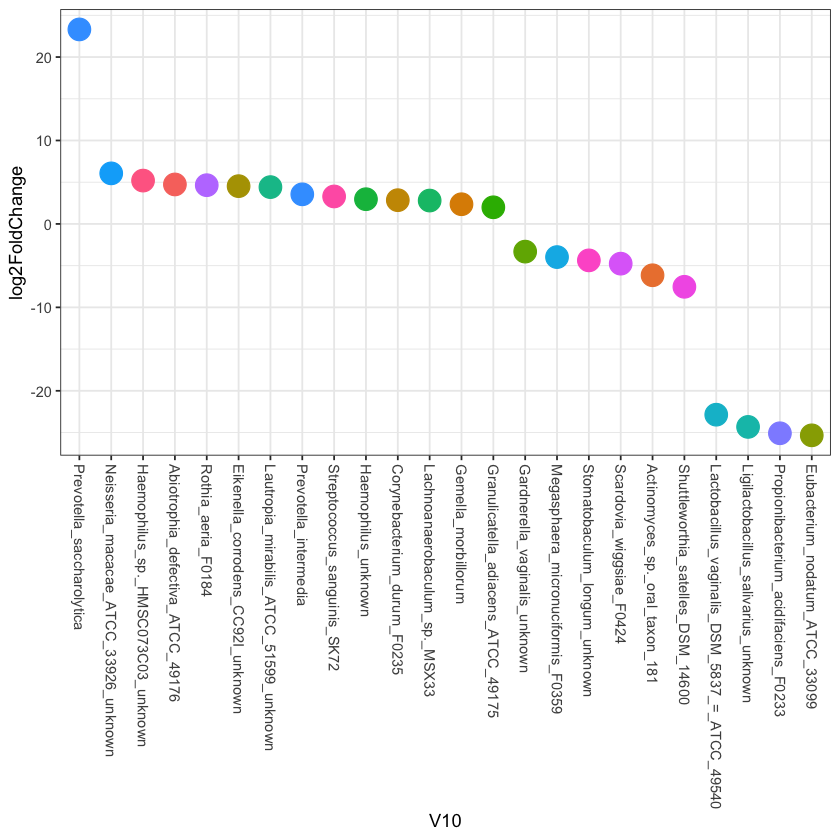

In [60]:
theme_set(theme_bw())
scale_fill_discrete <- function(palname = "Set1", ...) {
    scale_fill_brewer(palette = palname, ...)
}
# Phylum order
x = tapply(sigtab$log2FoldChange, sigtab$V10, function(x) max(x))
x = sort(x, TRUE)
sigtab$V10 = factor(as.character(sigtab$V10), levels=names(x))
# Genus order
x = tapply(sigtab$log2FoldChange, sigtab$V10, function(x) max(x))
x = sort(x, TRUE)
sigtab$V10 = factor(as.character(sigtab$V10), levels=names(x))
ggplot(sigtab, aes(x=V10, y=log2FoldChange, color=V8)) + geom_point(size=6) + 
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) + theme(legend.position = "none")
pdf("diff_abundance.taxglom.pdf")
ggplot(sigtab, aes(x=V10, y=log2FoldChange, color=V8)) + geom_point(size=6) + 
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
dev.off()

In [61]:
allres <- results(res, independentFiltering = FALSE)
allres <- allres[order(allres$padj, na.last = NA),]
allres <- cbind(as(allres, "data.frame"), as(tax_table(ps.dat)[rownames(allres),], "matrix"))
write.table(allres, "full_deseq_results.collapse_species_rpoc.txt")

In [62]:
# want to get fold changes per sample from deseq results
mcols(mcols(res), use.names=TRUE)$description
head(mcols(res))

[1] "mean of normalized counts for all samples"    
 [2] "variance of normalized counts for all samples"
 [3] "all counts for a gene are zero"               
 [4] "gene-wise estimates of dispersion"            
 [5] "number of iterations for gene-wise"           
 [6] "fitted values of dispersion"                  
 [7] "final estimate of dispersion"                 
 [8] "number of iterations"                         
 [9] "dispersion flagged as outlier"                
[10] "maximum a posteriori estimate"                
[11] "log2 fold change (MLE): Intercept"            
[12] "log2 fold change (MLE): tooth type PF vs PD"  
[13] "standard error: Intercept"                    
[14] "standard error: tooth type PF vs PD"          
[15] "Wald statistic: Intercept"                    
[16] "Wald statistic: tooth type PF vs PD"          
[17] "Wald test p-value: Intercept"                 
[18] "Wald test p-value: tooth type PF vs PD"       
[19] "convergence of betas"                         
[20] "iterations for betas"                         
[21] "deviance for the fitted model"                
[22] "maximum Cook's distance for row"              
[23] "had counts replaced"

DataFrame with 6 rows and 23 columns
          baseMean     baseVar   allZero dispGeneEst dispGeneIter   dispFit
         <numeric>   <numeric> <logical>   <numeric>    <numeric> <numeric>
ASV132  37.0813597 8221.124740     FALSE 10.48302645            8   12.2797
ASV69    1.9176056   76.177870     FALSE 60.00000000           13   56.3771
ASV552   0.0290984    0.050803     FALSE  0.00000001            1   38.7404
ASV381  15.9320532 2213.311323     FALSE 26.74531339           10   23.9039
ASV135   2.0313174  150.991853     FALSE 60.00000000           24   55.7868
ASV1235  0.0000000    0.000000      TRUE 60.00000000            9   58.0118
        dispersion  dispIter dispOutlier   dispMAP Intercept
         <numeric> <numeric>   <logical> <numeric> <numeric>
ASV132     10.7984        11       FALSE   10.7984   5.71044
ASV69      60.0000         9       FALSE   60.0000   2.09330
ASV552     60.0000         9       FALSE   60.0000  -2.14967
ASV381     25.8276        10       FALSE   25.8276

pdf 
  2

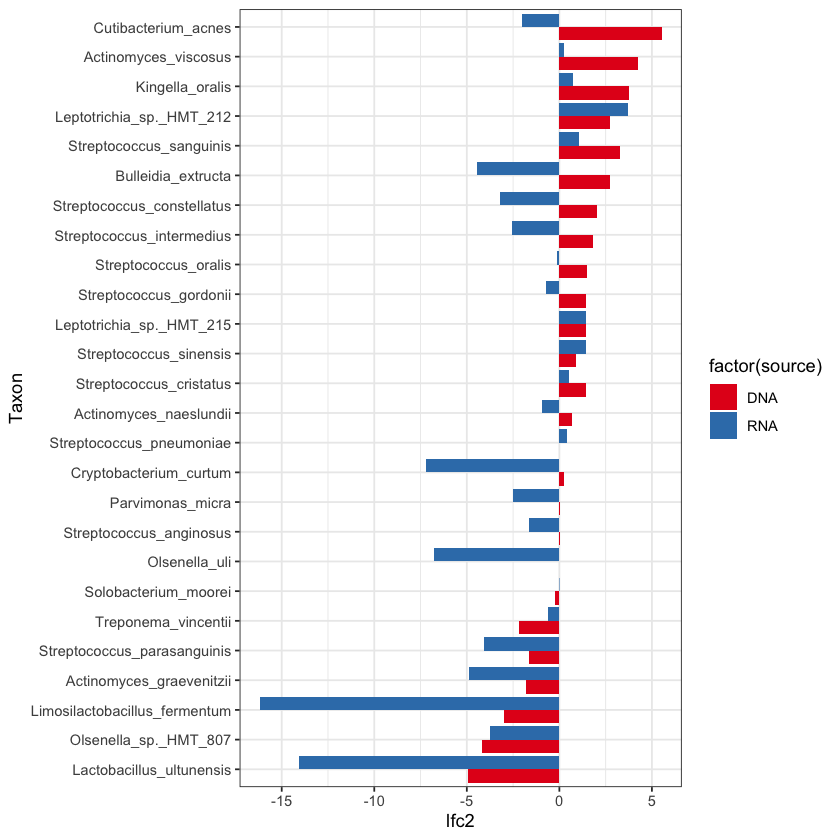

In [63]:
# log fold change figure and correlation
lfc <- read.table("logFC_for_plot.txt", header=T)
# head(lfc)
# reorder
lfc$Taxon <- with(lfc, reorder(Taxon, lfc2, max))

ggplot(lfc, aes(x=Taxon, y=lfc2, group=source)) + 
    geom_bar(stat="identity", aes(fill=factor(source)), position=position_dodge(width=0.9)) +
    coord_flip()

pdf("log2FC_plot_DNA_v_RNA.pdf")
ggplot(lfc, aes(x=Taxon, y=lfc2, group=source)) + 
    geom_bar(stat="identity", aes(fill=factor(source)), position=position_dodge(width=0.9)) +
    coord_flip()
dev.off()


`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



pdf 
  2


	Pearson's product-moment correlation

data:  temp$lfc2.DNA and temp$lfc2.RNA
t = 3.777, df = 24, p-value = 0.0009238
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2923825 0.8070574
sample estimates:
      cor 
0.6105829 


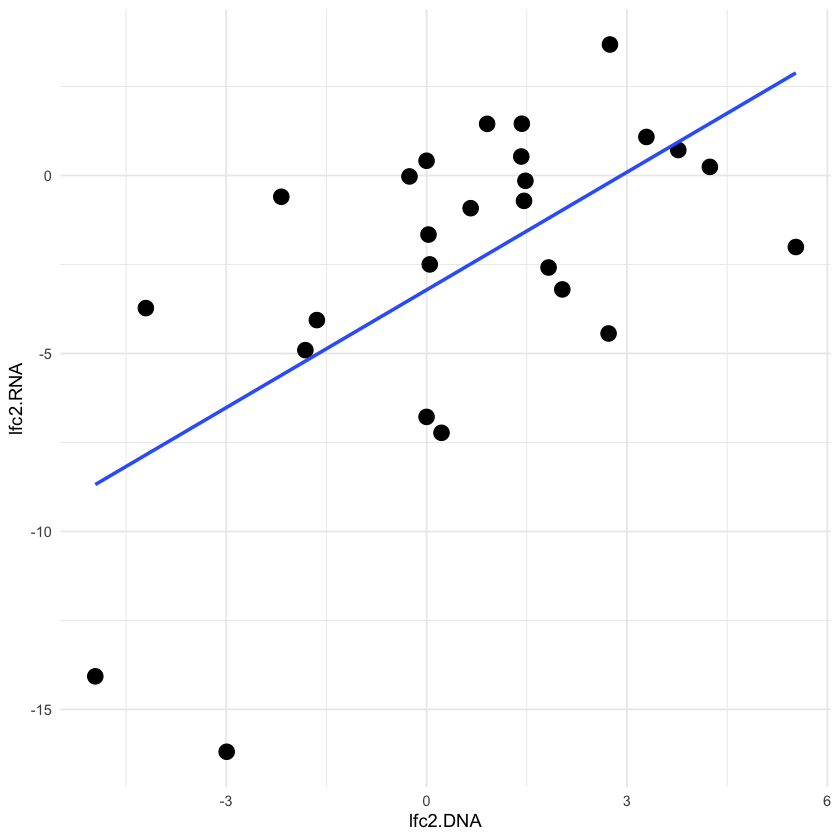

In [64]:
# correlation between lot2 fold change
temp <- reshape(lfc, idvar="Taxon", timevar="source", direction="wide")

ggplot(temp, aes(x=lfc2.DNA, y=lfc2.RNA)) + 
    geom_point(size = 4) + 
    theme_minimal() + 
    geom_smooth(method=lm, se=FALSE, fullrange=TRUE) 

pdf("dna_vs_rna_corplot.pdf")
ggplot(temp, aes(x=lfc2.DNA, y=lfc2.RNA)) + 
    geom_point(size = 4) + 
    theme_minimal() + 
    geom_smooth(method=lm, se=FALSE, fullrange=TRUE)
dev.off()

cor.test(temp$lfc2.DNA, temp$lfc2.RNA)

In [66]:
# correlation with ADS activity (citrulline production) of specific species
head(sample_data(ps.dat))

,tooth_type,individual_id,caries_status,original_sample_id,novaseq_id,volume_used_ul,protein_mg_ml,ads_nmol_min_mg_of_protein,concentration_ng_ul,Prop_Smutans,Smutans_cat,log2_ads
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<dbl>
UF106PFR,PF,PF,CA,B106-PFR,106PFR,80,0.399,17,14.46,0.00,low,4.087463
UF10PD,PD,PD,CA,B10-PD,10PD,120,0.153,8,7.74,10.45,high,3.000000
UF115PD,PD,PD,CA,B115-PD,115PD,120,0.083,20,26.51,0.00,low,4.321928
UF12PD,PD,PD,CA,B12-PD,12PD,80,0.222,16,5.29,42.47,high,4.000000
UF13PF,PF,PF,CF,B13-PF,13PF,40,0.380,58,25.43,0.58,low,5.857981
UF14PF,PF,PF,CF,B14-PF,14PF,40,0.266,55,36.07,0.19,low,5.781360


Warning message in FUN(X[[i]], ...):
“merge_taxa attempted to reduce tree to 1 or fewer tips.
 tree replaced with NULL.”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 14 rows containing non-finite values (stat_smooth).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 14 rows containing non-finite values (stat_smooth).”


pdf 
  2


Call:
lm(formula = V1 ~ V2, data = temp)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.5096 -1.1659  0.1989  1.5467  4.5952 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)   4.1709     1.5733   2.651   0.0111 *
V2            0.5066     0.3221   1.573   0.1229  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.089 on 44 degrees of freedom
  (14 observations deleted due to missingness)
Multiple R-squared:  0.05323,	Adjusted R-squared:  0.03171 
F-statistic: 2.474 on 1 and 44 DF,  p-value: 0.1229


Warning message in FUN(X[[i]], ...):
“merge_taxa attempted to reduce tree to 1 or fewer tips.
 tree replaced with NULL.”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 44 rows containing non-finite values (stat_smooth).”


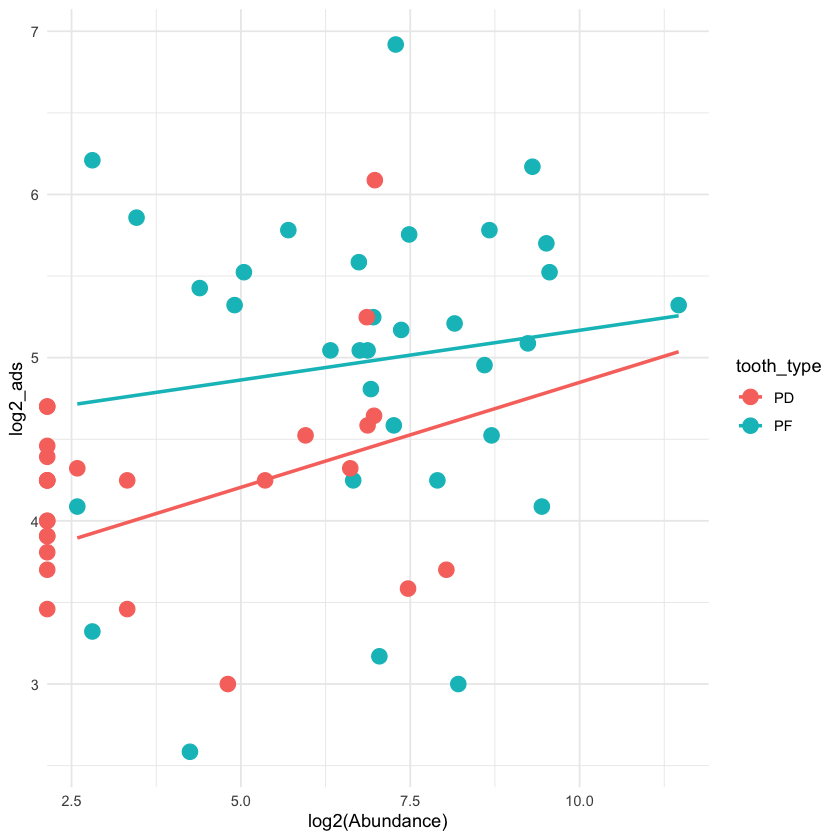

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 44 rows containing non-finite values (stat_smooth).”


pdf 
  2

Warning message in FUN(X[[i]], ...):
“merge_taxa attempted to reduce tree to 1 or fewer tips.
 tree replaced with NULL.”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 32 rows containing non-finite values (stat_smooth).”


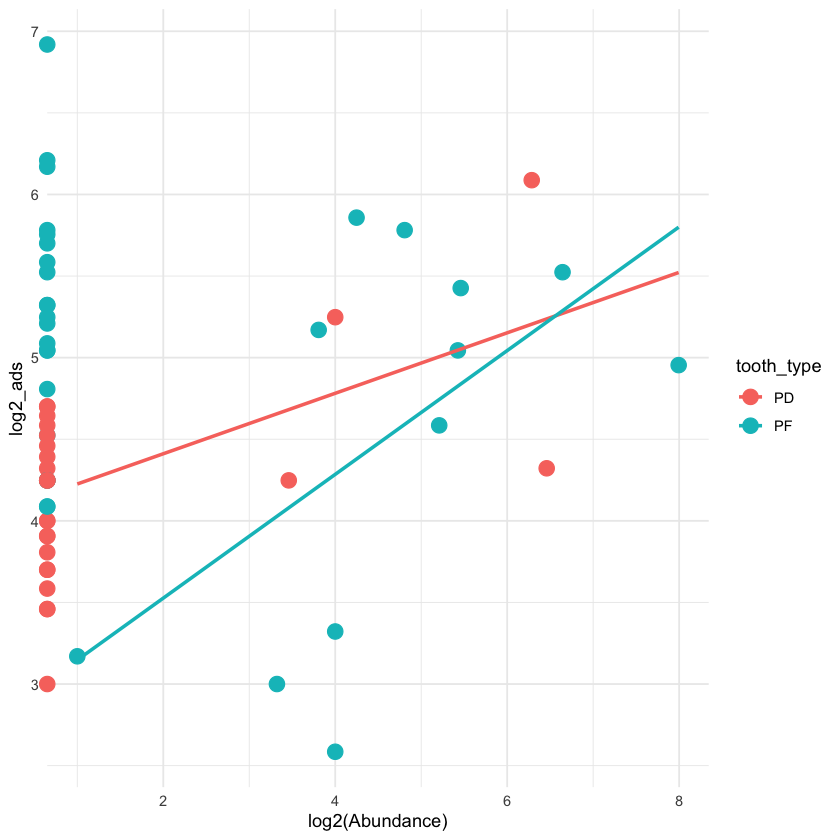

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 32 rows containing non-finite values (stat_smooth).”


pdf 
  2


Call:
lm(formula = V1 ~ V2, data = temp)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.0859 -1.4540 -0.4507  1.6383  3.7387 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)   6.2969     1.9508   3.228  0.00336 **
V2           -0.2057     0.3921  -0.525  0.60432   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.003 on 26 degrees of freedom
  (32 observations deleted due to missingness)
Multiple R-squared:  0.01047,	Adjusted R-squared:  -0.02759 
F-statistic: 0.2752 on 1 and 26 DF,  p-value: 0.6043


Warning message in FUN(X[[i]], ...):
“merge_taxa attempted to reduce tree to 1 or fewer tips.
 tree replaced with NULL.”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 23 rows containing non-finite values (stat_smooth).”


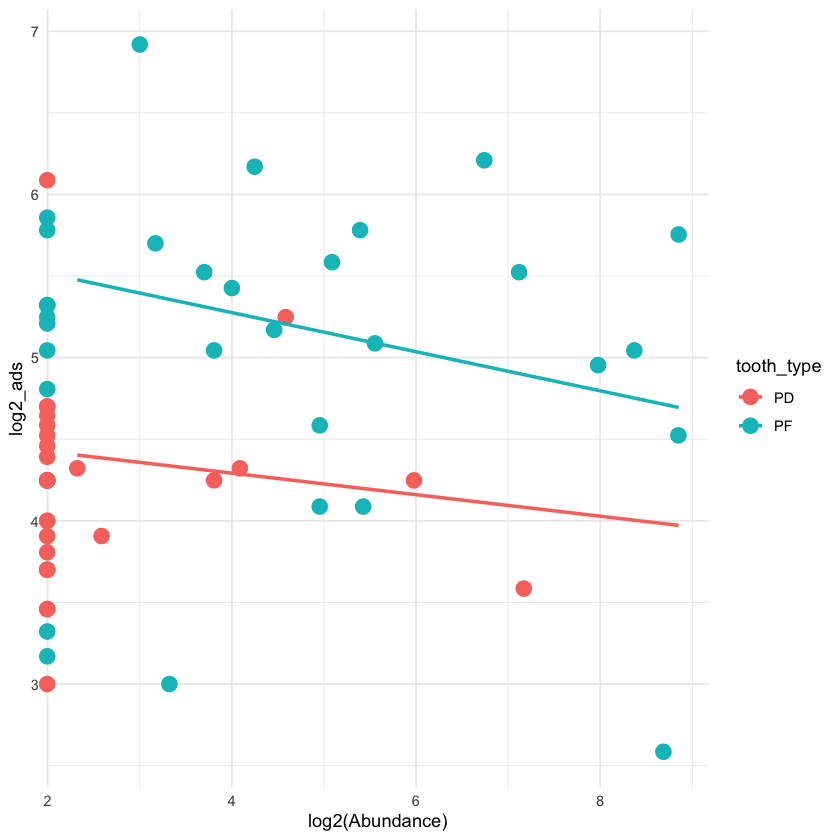

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 23 rows containing non-finite values (stat_smooth).”


pdf 
  2


Call:
lm(formula = V1 ~ V2, data = temp)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.2494 -1.9067 -0.2578  2.3462  5.9417 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)   8.8336     2.6597   3.321   0.0021 **
V2           -0.2889     0.5864  -0.493   0.6254   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.061 on 35 degrees of freedom
  (23 observations deleted due to missingness)
Multiple R-squared:  0.006884,	Adjusted R-squared:  -0.02149 
F-statistic: 0.2426 on 1 and 35 DF,  p-value: 0.6254


Warning message in FUN(X[[i]], ...):
“merge_taxa attempted to reduce tree to 1 or fewer tips.
 tree replaced with NULL.”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 26 rows containing non-finite values (stat_smooth).”


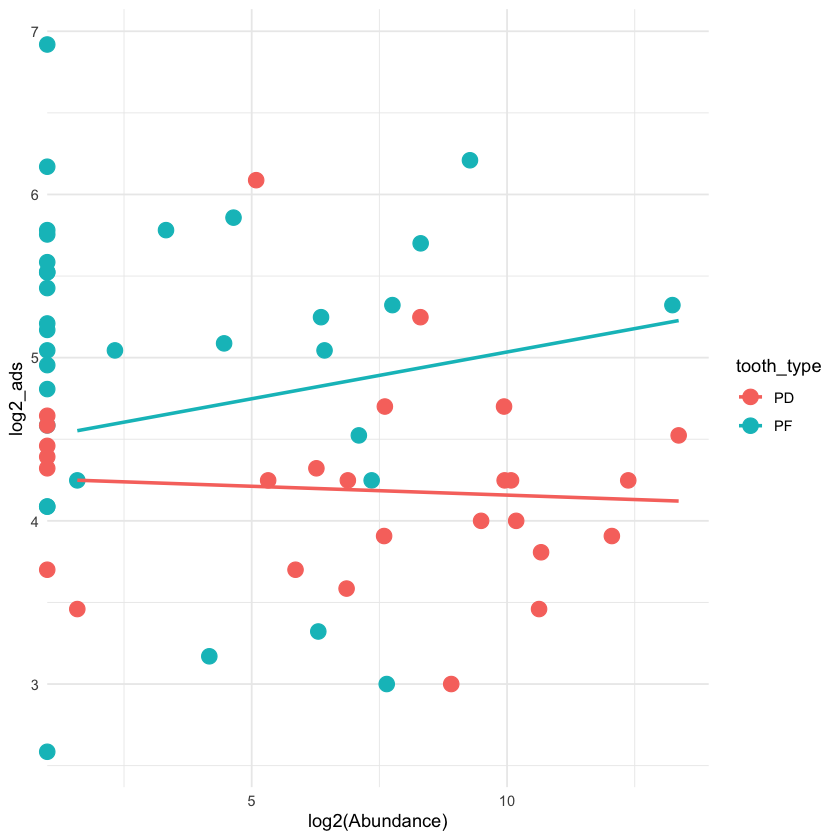

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 26 rows containing non-finite values (stat_smooth).”


pdf 
  2


Call:
lm(formula = V1 ~ V2, data = temp)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.8881 -0.7159  0.3452  1.4266  2.6195 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   8.4264     1.6092   5.236 9.99e-06 ***
V2           -0.5114     0.3389  -1.509    0.141    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.823 on 32 degrees of freedom
  (26 observations deleted due to missingness)
Multiple R-squared:  0.06643,	Adjusted R-squared:  0.03726 
F-statistic: 2.277 on 1 and 32 DF,  p-value: 0.1411


Warning message in FUN(X[[i]], ...):
“merge_taxa attempted to reduce tree to 1 or fewer tips.
 tree replaced with NULL.”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 26 rows containing non-finite values (stat_smooth).”


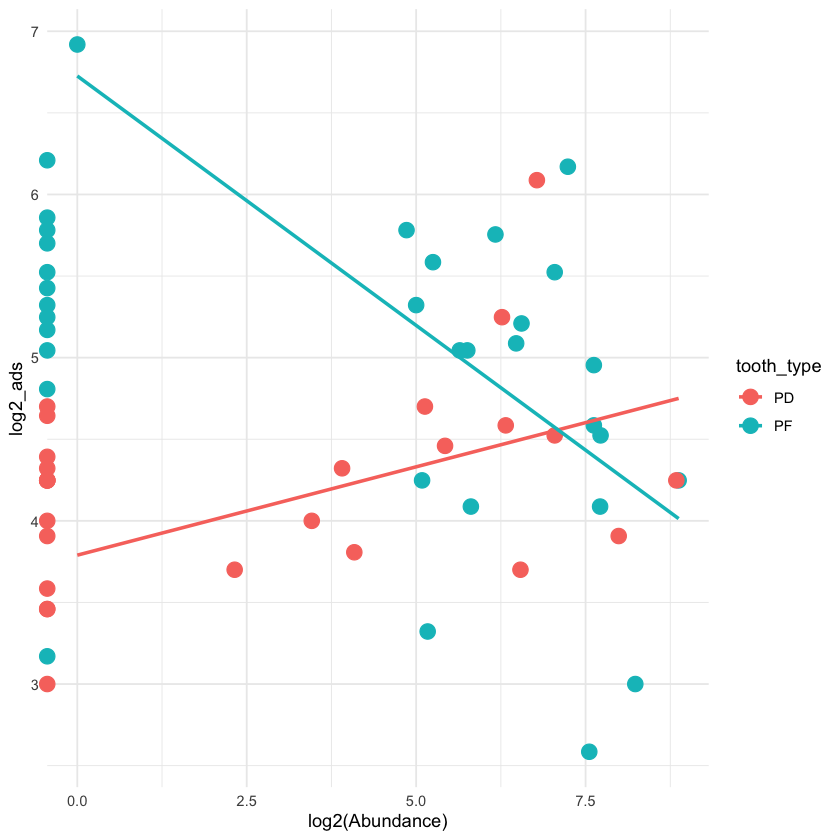

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 26 rows containing non-finite values (stat_smooth).”


pdf 
  2


Call:
lm(formula = V1 ~ V2, data = temp)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.8046 -1.2003 -0.0469  1.1090  4.8050 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   6.5455     1.7725   3.693 0.000823 ***
V2           -0.2890     0.3847  -0.751 0.457938    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.989 on 32 degrees of freedom
  (26 observations deleted due to missingness)
Multiple R-squared:  0.01734,	Adjusted R-squared:  -0.01337 
F-statistic: 0.5645 on 1 and 32 DF,  p-value: 0.4579


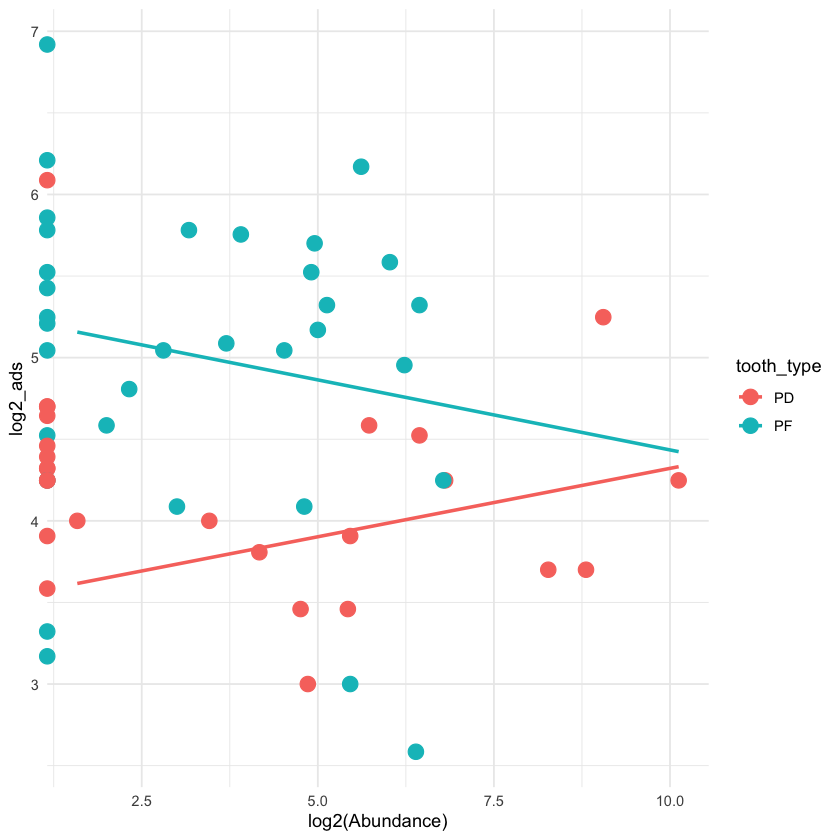

In [67]:
# different taxa affect on citrulline production
strep <- subset_taxa(ps.dat, V9=="Streptococcus_sanguinis") 
glom <- tax_glom(strep, taxrank=rank_names(strep)[8])
data <- psmelt(glom) # create dataframe from phyloseq object
data$Sample <- factor(data$Sample, levels=unique(data$Sample))
# plot
ggplot(data, aes(x=log2(Abundance), y=log2_ads, color=tooth_type)) + 
    geom_point(size = 4) + 
    theme_minimal() + 
    geom_smooth(method=lm, se=FALSE, fullrange=TRUE) +
#     geom_rug(outside = TRUE, sides = "tr", linewidth = 10) +
    coord_cartesian(clip = "off")

pdf("correlation_citrulline_ssanguinis.pdf")
ggplot(data, aes(x=log2(Abundance), y=log2_ads, color=tooth_type)) + 
    geom_point(size = 4) + 
    theme_minimal() + 
    geom_smooth(method=lm, se=FALSE, fullrange=TRUE) +
#     geom_rug(outside = TRUE, sides = "tr", linewidth = 10) +
    coord_cartesian(clip = "off")
dev.off()

temp <- cbind(log2(data$Abundance), data$log2_ads)
temp[is.na(temp) | temp=="-Inf"] <- NA
temp <- as.data.frame(temp)
summary(lm(V1~V2, data=temp))

strep <- subset_taxa(ps.dat, V9=="Leptotrichia_sp._oral_taxon_215") 
glom <- tax_glom(strep, taxrank=rank_names(strep)[8])
data <- psmelt(glom) # create dataframe from phyloseq object
data$Sample <- factor(data$Sample, levels=unique(data$Sample))
# plot
ggplot(data, aes(x=log2(Abundance), y=log2_ads, color=tooth_type)) + 
    geom_point(size = 4) + 
    theme_minimal() + 
    geom_smooth(method=lm, se=FALSE, fullrange=TRUE) +
#     geom_rug(outside = TRUE, sides = "tr", linewidth = 10) +
    coord_cartesian(clip = "off")

pdf("correlation_citrulline_lepto215.pdf")
ggplot(data, aes(x=log2(Abundance), y=log2_ads, color=tooth_type)) + 
    geom_point(size = 4) + 
    theme_minimal() + 
    geom_smooth(method=lm, se=FALSE, fullrange=TRUE) +
#     geom_rug(outside = TRUE, sides = "tr", linewidth = 10) +
    coord_cartesian(clip = "off")
dev.off()

strep <- subset_taxa(ps.dat, V9=="Leptotrichia_sp._oral_taxon_212") 
glom <- tax_glom(strep, taxrank=rank_names(strep)[8])
data <- psmelt(glom) # create dataframe from phyloseq object
data$Sample <- factor(data$Sample, levels=unique(data$Sample))
# plot
ggplot(data, aes(x=log2(Abundance), y=log2_ads, color=tooth_type)) + 
    geom_point(size = 4) + 
    theme_minimal() + 
    geom_smooth(method=lm, se=FALSE, fullrange=TRUE) +
#     geom_rug(outside = TRUE, sides = "tr", linewidth = 10) +
    coord_cartesian(clip = "off")

pdf("correlation_citrulline_lepto212.pdf")
ggplot(data, aes(x=log2(Abundance), y=log2_ads, color=tooth_type)) + 
    geom_point(size = 4) + 
    theme_minimal() + 
    geom_smooth(method=lm, se=FALSE, fullrange=TRUE) +
#     geom_rug(outside = TRUE, sides = "tr", linewidth = 10) +
    coord_cartesian(clip = "off")
dev.off()

temp <- cbind(log2(data$Abundance), data$log2_ads)
temp[is.na(temp) | temp=="-Inf"] <- NA
temp <- as.data.frame(temp)
summary(lm(V1~V2, data=temp))

strep <- subset_taxa(ps.dat, V9=="Streptococcus_mutans") 
glom <- tax_glom(strep, taxrank=rank_names(strep)[8])
data <- psmelt(glom) # create dataframe from phyloseq object
data$Sample <- factor(data$Sample, levels=unique(data$Sample))
# plot
ggplot(data, aes(x=log2(Abundance), y=log2_ads, color=tooth_type)) + 
    geom_point(size = 4) + 
    theme_minimal() + 
    geom_smooth(method=lm, se=FALSE, fullrange=TRUE) +
#     geom_rug(outside = TRUE, sides = "tr", linewidth = 10) +
    coord_cartesian(clip = "off")

pdf("correlation_citrulline_smutans.pdf")
ggplot(data, aes(x=log2(Abundance), y=log2_ads, color=tooth_type)) + 
    geom_point(size = 4) + 
    theme_minimal() + 
    geom_smooth(method=lm, se=FALSE, fullrange=TRUE) +
#     geom_rug(outside = TRUE, sides = "tr", linewidth = 10) +
    coord_cartesian(clip = "off")
dev.off()

temp <- cbind(log2(data$Abundance), data$log2_ads)
temp[is.na(temp) | temp=="-Inf"] <- NA
temp <- as.data.frame(temp)
summary(lm(V1~V2, data=temp))

strep <- subset_taxa(ps.dat, V9=="Streptococcus_oralis") 
glom <- tax_glom(strep, taxrank=rank_names(strep)[8])
data <- psmelt(glom) # create dataframe from phyloseq object
data$Sample <- factor(data$Sample, levels=unique(data$Sample))
# plot
ggplot(data, aes(x=log2(Abundance), y=log2_ads, color=tooth_type)) + 
    geom_point(size = 4) + 
    theme_minimal() + 
    geom_smooth(method=lm, se=FALSE, fullrange=TRUE) +
#     geom_rug(outside = TRUE, sides = "tr", linewidth = 10) +
    coord_cartesian(clip = "off")

pdf("correlation_citrulline_soralis.pdf")
ggplot(data, aes(x=log2(Abundance), y=log2_ads, color=tooth_type)) + 
    geom_point(size = 4) + 
    theme_minimal() + 
    geom_smooth(method=lm, se=FALSE, fullrange=TRUE) +
#     geom_rug(outside = TRUE, sides = "tr", linewidth = 10) +
    coord_cartesian(clip = "off")
dev.off()

temp <- cbind(log2(data$Abundance), data$log2_ads)
temp[is.na(temp) | temp=="-Inf"] <- NA
temp <- as.data.frame(temp)
summary(lm(V1~V2, data=temp))

strep <- subset_taxa(ps.dat, V9=="Streptococcus_parasanguinis") 
glom <- tax_glom(strep, taxrank=rank_names(strep)[8])
data <- psmelt(glom) # create dataframe from phyloseq object
data$Sample <- factor(data$Sample, levels=unique(data$Sample))
# plot
ggplot(data, aes(x=log2(Abundance), y=log2_ads, color=tooth_type)) + 
    geom_point(size = 4) + 
    theme_minimal() + 
    geom_smooth(method=lm, se=FALSE, fullrange=TRUE) +
#     geom_rug(outside = TRUE, sides = "tr", linewidth = 10) +
    coord_cartesian(clip = "off")

pdf("correlation_citrulline_sparasanguinis.pdf")
ggplot(data, aes(x=log2(Abundance), y=log2_ads, color=tooth_type)) + 
    geom_point(size = 4) + 
    theme_minimal() + 
    geom_smooth(method=lm, se=FALSE, fullrange=TRUE) +
#     geom_rug(outside = TRUE, sides = "tr", linewidth = 10) +
    coord_cartesian(clip = "off")
dev.off()

temp <- cbind(log2(data$Abundance), data$log2_ads)
temp[is.na(temp) | temp=="-Inf"] <- NA
temp <- as.data.frame(temp)
summary(lm(V1~V2, data=temp))

In [74]:
# now need to get log abundance and count histograms for each of the ADS species in log fold change plot
abct <- read.table("abundance_count.txt", header=T)
head(abct)

,Taxon,Sum,Count,Prop,log10_sum,order
,<chr>,<int>,<int>,<dbl>,<dbl>,<int>
1,Cutibacterium_acnes,843,9,15.00,2.93,1
2,Actinomyces_viscosus,145,5,8.33,2.16,2
3,Kingella_oralis,278,9,15.00,2.44,3
4,Leptotrichia_sp._HMT_212,2776,28,46.67,3.44,4
5,Streptococcus_sanguinis,11172,46,76.67,4.05,5
6,Bulleidia_extructa,161,5,8.33,2.21,6


pdf 
  2

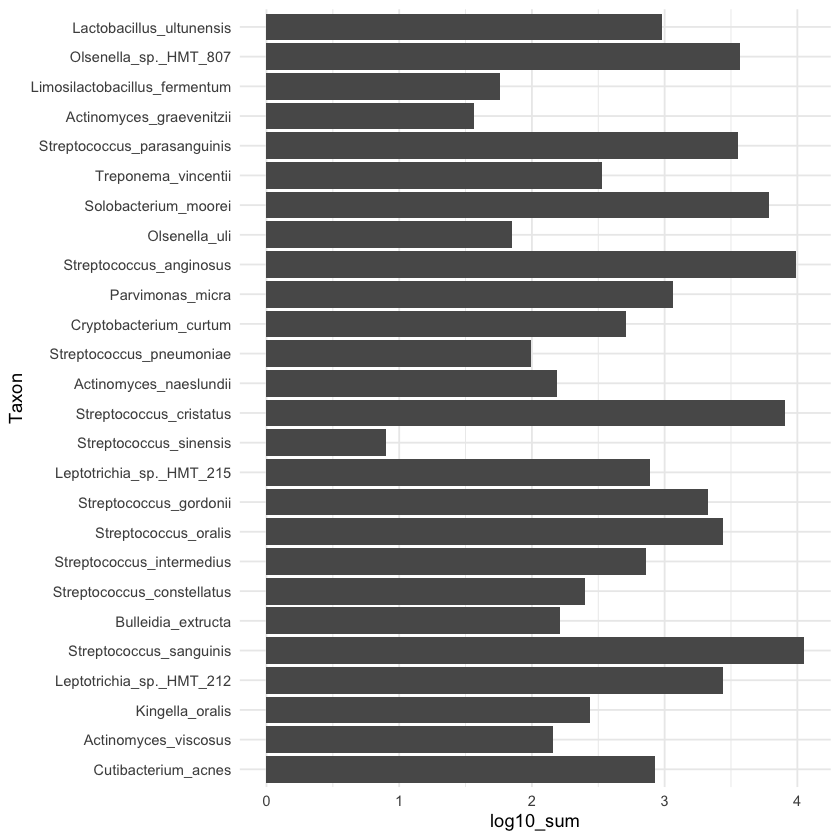

pdf 
  2

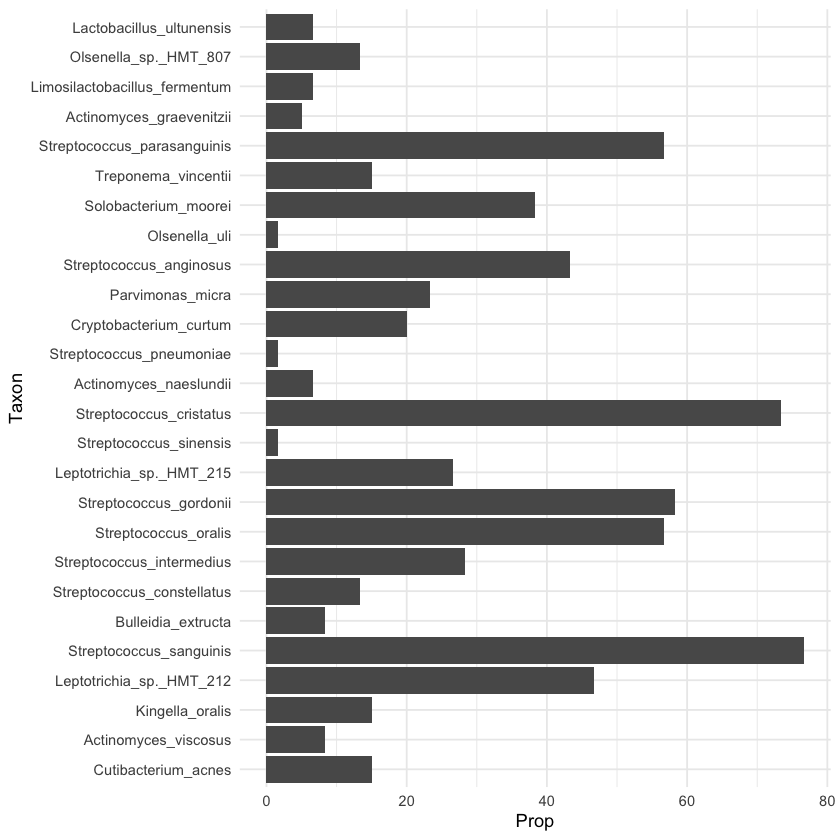

In [83]:
# reorder
abct$Taxon <- with(abct, reorder(Taxon, order, max))
# head(abct)
ggplot(abct, aes(x=Taxon, y=log10_sum)) + 
    geom_bar(stat="identity") +
    coord_flip() + theme_minimal()

pdf("abundance_barplot.pdf")
ggplot(abct, aes(x=Taxon, y=log10_sum)) + 
    geom_bar(stat="identity") +
    coord_flip() + theme_minimal()
dev.off()

ggplot(abct, aes(x=Taxon, y=Prop)) + 
    geom_bar(stat="identity") +
    coord_flip() + theme_minimal()

pdf("proportion_barplot.pdf")
ggplot(abct, aes(x=Taxon, y=Prop)) + 
    geom_bar(stat="identity") +
    coord_flip() + theme_minimal()
dev.off()